In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Andrea's Part :)

In [ ]:
# Reading file and defining dataframe for analysis
P1 = 'SMM921_trading_data_2024.csv'
dfp1 = pd.read_csv(P1)

dfp1

# Reformatting date to fit pandas logic
dfp1['datereformat'] = pd.to_datetime(dfp1['Date-Time'].str[:29], format="%Y-%m-%dT%H:%M:%S.%f")

# Dropping obsolete columns 
dfp1 = dfp1.drop(columns=['Date-Time'])

# Assigning index property to the reformatted date
dfp1.set_index('datereformat', inplace=True)

# criterio per selezionare gli stocks minimum spread :) 

# Calculating Midquote
dfp1['Midquote'] = (dfp1['Close Bid'] + dfp1['Close Ask']) / 2

# Calculating Midquote as a percentage change
dfp1['Midquote Returns'] = dfp1['Midquote'].pct_change() * 10000 # we want bps 

# Calculating the Spread
dfp1['Spread'] = 10000 * ((dfp1['Close Ask'] - dfp1['Close Bid']) / dfp1['Midquote']) # we want bps

# Calculating Depth (not sure about the /2)
# depth defined as mean number of shares across the best bid and best ask sides of the market (check)
# we used numbers :)
dfp1['Depth'] = (dfp1['Close Bid Size'] + dfp1['Close Ask Size']) / 2 

# fitering for specific stocks
dfp1 = dfp1[dfp1['Stock'].isin(['EXPN.L', 'GSK.L', 'CPG.L'])]

# filtering for specific timeframe
dfp1 = dfp1.between_time('08:15', '16:25') # LSE begins and ends with an auction; its different from the majority of trading days wich are continous and sequential tradings

# filtering for only positive spread
dfp1 = dfp1[dfp1['Spread'] >= 0]

# we might want to use fillna in this case .fillna(0)

# n.a. replacing them with 0s
dfp1.fillna(0)

dfp1

# validating uniqueness of the stock column for plotting
stocks = dfp1['Stock'].unique()

# Looking for each unique stock
for stock in stocks:
    stock_data = dfp1[dfp1['Stock'] == stock]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plotting Spread
    axs[0].bar(stock_data.index, stock_data['Spread'], label='Spread', color='blue')
    axs[0].set_title(f'Time-Series of Spread for {stock} (Bar Chart)')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Spread')
    axs[0].legend()

    # Plotting Depth
    axs[1].bar(stock_data.index, stock_data['Depth'], label='Depth', color='green')
    axs[1].set_title(f'Time-Series of Depth for {stock} (Bar Chart)')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Depth')
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*50 + "\n")

#  need to take outliers away so i do the below to check first

# Plotting the variables in a scatterplot to see if there is any correlation (i would assume negative)
# Looking at the distribution with KDE 
# Computing the OLS to see relationship of the two variables

for stock in stocks:
    stock_data = dfp1[dfp1['Stock'] == stock]
    
    # Scatter plots
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.scatter(stock_data['Depth'], stock_data['Spread'], label='Spread vs Depth', color='red')
    ax.set_title(f'Scatter Plot of Spread vs Depth for {stock}')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Spread')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Distribution plots 
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    sns.histplot(stock_data['Spread'], kde=True, ax=axs[0], color='blue')
    axs[0].set_title(f'Distribution of Spread for {stock}')
    axs[0].set_xlabel('Spread')
    axs[0].set_ylabel('Frequency')
    
    sns.histplot(stock_data['Depth'], kde=True, ax=axs[1], color='green')
    axs[1].set_title(f'Distribution of Depth for {stock}')
    axs[1].set_xlabel('Depth')
    axs[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Running OLS regression
    X = stock_data['Depth']
    y = stock_data['Spread']
    X = sm.add_constant(X)  # adding a constant

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    print(f"OLS Regression Results for {stock}:")
    print(model.summary())
    print("\n" + "="*50 + "\n")

# There are some outliers where Spread is higher than usual, 
# but these are rare compared to the main clusters so we can exclude them

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing the outliers based on function above
dfp1 = remove_outliers(dfp1, 'Spread')
dfp1 = remove_outliers(dfp1, 'Depth')

# lets plot again having excluded outliers
for stock in stocks:
    stock_data = dfp1[dfp1['Stock'] == stock]
    
    # Scatter plots
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.scatter(stock_data['Depth'], stock_data['Spread'], label='Spread vs Depth', color='red')
    ax.set_title(f'Scatter Plot of Spread vs Depth for {stock}')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Spread')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Distribution plots 
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    sns.histplot(stock_data['Spread'], kde=True, ax=axs[0], color='blue')
    axs[0].set_title(f'Distribution of Spread for {stock}')
    axs[0].set_xlabel('Spread')
    axs[0].set_ylabel('Frequency')
    
    sns.histplot(stock_data['Depth'], kde=True, ax=axs[1], color='green')
    axs[1].set_title(f'Distribution of Depth for {stock}')
    axs[1].set_xlabel('Depth')
    axs[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Defining summary statistics and printing them
    spread_summary2 = stock_data['Spread'].describe()
    depth_summary2 = stock_data['Depth'].describe()
    
    print(f"Spread Summary Statistics for {stock}:")
    print(spread_summary2)
    
    print(f"\nDepth Summary Statistics for {stock}:")
    print(depth_summary2)
    print("\n" + "="*50 + "\n")

If the histogram of the spread shows a concentration around lower values (e.g., close to 1 or 2), it suggests that EXPN.L generally has a tight spread, implying good liquidity.
If the spread has frequent outliers or higher values, it indicates periods of lower liquidity.
Depth:
A histogram with higher values of depth implies better liquidity. If EXPN.L shows a distribution with a substantial number of shares at each price level, it indicates robust market depth.

# validating uniqueness of the stock column for plotting
stocks = dfp1['Stock'].unique()

# Looking for each unique stock
for stock in stocks:
    stock_data = dfp1[dfp1['Stock'] == stock]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plotting Spread
    axs[0].bar(stock_data.index, stock_data['Spread'], label='Spread', color='blue')
    axs[0].set_title(f'Time-Series of Spread for {stock} (Bar Chart)')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Spread')
    axs[0].legend()

    # Plotting Depth
    axs[1].bar(stock_data.index, stock_data['Depth'], label='Depth', color='green')
    axs[1].set_title(f'Time-Series of Depth for {stock} (Bar Chart)')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Depth')
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*50 + "\n")









# Add an hour column for aggregation
dfp1['Hour'] = dfp1.index.hour

# i am using a simple mean here we can use a geomean or a wmean if we need or want
for stock in stocks:
    stock_data = dfp1[dfp1['Stock'] == stock]
    
    hourly_means = stock_data.groupby('Hour').agg({
        'Spread': 'mean',
        'Depth': 'mean'
    }).reset_index()
    
    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot mean spread per hour
    sns.lineplot(data=hourly_means, x='Hour', y='Spread', ax=axs[0], marker='o')
    axs[0].set_title(f'Mean Spread per Hour for {stock}')
    axs[0].set_xlabel('Hour of the Day')
    axs[0].set_ylabel('Mean Spread')

    # Plot mean depth per hour
    sns.lineplot(data=hourly_means, x='Hour', y='Depth', ax=axs[1], marker='o')
    axs[1].set_title(f'Mean Depth per Hour for {stock}')
    axs[1].set_xlabel('Hour of the Day')
    axs[1].set_ylabel('Mean Depth')

    plt.tight_layout()
    plt.show()

# Filtering for a specific stock (EXPN.L)
dfp1expn = dfp1[dfp1['Stock'] == 'EXPN.L']

# Defining the day column for the calculations
dfp1expn['Day'] = dfp1expn.index.date

# Calculate daily averages and volatility
daily_stats = dfp1expn.groupby('Day').agg({
    'Spread': 'mean',
    'Depth': 'mean',
    'Midquote Returns': lambda x: x.abs().mean()
}).rename(columns={'Midquote Returns': 'Midquote Volatility'})

dfp1expn

# Setting up average plots (i used standard mean in this case but we can use geomean too)
fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Spread plot
axs[0].plot(daily_stats.index, daily_stats['Spread'], marker='o')
axs[0].set_title('Daily Average Spread for EXPN.L')
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Average Spread')

# Depth Plot
axs[1].plot(daily_stats.index, daily_stats['Depth'], marker='o')
axs[1].set_title('Daily Average Depth for EXPN.L')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Average Depth')

# Midquote Volatility plot
axs[2].plot(daily_stats.index, daily_stats['Midquote Volatility'], marker='o')
axs[2].set_title('Daily Midquote Volatility for EXPN.L')
axs[2].set_xlabel('Day')
axs[2].set_ylabel('Midquote Volatility')

plt.tight_layout()
plt.show()

# Step 1: Correlation Analysis
correlation = daily_stats['Spread'].corr(daily_stats['Depth'])
print(f"Correlation between daily average spreads and depth: {correlation}")

# Running regression for vol
X_volatility = daily_stats['Midquote Volatility']
y_spread = daily_stats['Spread']
X_volatility = sm.add_constant(X_volatility)  # adding a constant

model_volatility = sm.OLS(y_spread, X_volatility).fit()
print("Regression Results of Spread on Volatility:")
print(model_volatility.summary())

# Regression for depth
X_depth = daily_stats['Depth']
X_depth = sm.add_constant(X_depth)  # adding a constant

model_depth = sm.OLS(y_spread, X_depth).fit()
print("Regression Results of Spread on Depth:")
print(model_depth.summary())

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Scatter with line
sns.regplot(x='Depth', y='Spread', data=daily_stats, ax=axs[0])
axs[0].set_title('Regression of Spread on Depth')
axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Spread')

sns.regplot(x='Midquote Volatility', y='Spread', data=daily_stats, ax=axs[1])
axs[1].set_title('Regression of Spread on Volatility')
axs[1].set_xlabel('Midquote Volatility')
axs[1].set_ylabel('Spread')

plt.tight_layout()
plt.show()



# Part 1: Liquidity Analysis (Deprecated ?)

In [2]:
# Reading file and defining dataframe for analysis
P1 = 'SMM921_trading_data_2024.csv'
dfp1 = pd.read_csv(P1)

dfp1


# dobt drop nas but if you have missing values in the middle do the one before as assumption

,Stock,Date-Time,Last,Volume,No. Trades,Close Bid,Close Ask,Close Bid Size,Close Ask Size
0,AAL.L,2024-01-08T05:00:00.000000000Z,NaN,NaN,NaN,1850.0,2000.0,250.0,5000.0
1,AAL.L,2024-01-08T07:50:00.000000000Z,NaN,NaN,NaN,2244.5,1496.8,1828.0,2856.0
2,AAL.L,2024-01-08T07:51:00.000000000Z,NaN,NaN,NaN,2244.5,1496.8,1828.0,2946.0
3,AAL.L,2024-01-08T07:52:00.000000000Z,NaN,NaN,NaN,2244.5,1496.8,2059.0,2946.0
4,AAL.L,2024-01-08T07:53:00.000000000Z,NaN,NaN,NaN,2244.5,1496.8,1884.0,4639.0
...,...,...,...,...,...,...,...,...,...
645152,WPP.L,2024-03-28T17:59:00.000000000Z,NaN,40911.0,NaN,NaN,NaN,NaN,NaN
645153,WPP.L,2024-03-28T18:07:00.000000000Z,NaN,60796.0,NaN,NaN,NaN,NaN,NaN
645154,WPP.L,2024-03-28T18:09:00.000000000Z,NaN,44717.0,NaN,NaN,NaN,NaN,NaN
645155,WPP.L,2024-03-28T18:10:00.000000000Z,NaN,492.0,NaN,NaN,NaN,NaN,NaN


In [3]:
# Reformatting date to fit pandas logic
dfp1['datereformat'] = pd.to_datetime(dfp1['Date-Time'].str[:29], format="%Y-%m-%dT%H:%M:%S.%f")

# Dropping obsolete columns 
dfp1 = dfp1.drop(columns=['Date-Time'])

# Assigning index property to the reformatted date
dfp1.set_index('datereformat', inplace=True)

In [4]:
# criterio per selezionare gli stocks minimum spread :) 

In [5]:
# Calculating Midquote
dfp1['Midquote'] = (dfp1['Close Bid'] + dfp1['Close Ask']) / 2

# Calculating Midquote as a percentage change
dfp1['Midquote Returns'] = dfp1['Midquote'].pct_change() * 10000 # we want bps 

# Calculating the Spread
dfp1['Spread'] = 10000 * ((dfp1['Close Ask'] - dfp1['Close Bid']) / dfp1['Midquote']) # we want bps

# Calculating Depth (not sure about the /2)
# depth defined as mean number of shares across the best bid and best ask sides of the market (check)
# we used numbers :)
dfp1['Depth'] = (dfp1['Close Bid Size'] + dfp1['Close Ask Size']) / 2 

In [6]:
# fitering for specific stocks
dfp1 = dfp1[dfp1['Stock'].isin(['EXPN.L', 'BARC.L', 'CPG.L'])]

# filtering for specific timeframe
dfp1 = dfp1.between_time('08:15', '16:25') # LSE begins and ends with an auction; its different from the majority of trading days wich are continous and sequential tradings

# filtering for only positive spread
dfp1 = dfp1[dfp1['Spread'] >= 0]

# we might want to use fillna in this case .fillna(0)

# Dropping n.a.
dfp1.dropna()

dfp1

,Stock,Last,Volume,No. Trades,Close Bid,Close Ask,Close Bid Size,Close Ask Size,Midquote,Midquote Returns,Spread,Depth
datereformat,,,,,,,,,,,,
2024-01-08 08:15:00,BARC.L,NaN,57.0,NaN,155.30,155.38,2138.0,100.0,155.34,14.828186,5.149994,1119.0
2024-01-08 08:16:00,BARC.L,155.3800,11871.0,8.0,155.38,155.50,6191.0,3927.0,155.44,6.437492,7.720021,5059.0
2024-01-08 08:17:00,BARC.L,155.4800,16874.0,10.0,155.52,155.62,4079.0,3014.0,155.57,8.363356,6.427975,3546.5
2024-01-08 08:18:00,BARC.L,155.5800,12132.0,11.0,155.54,155.62,1301.0,100.0,155.58,0.642797,5.142049,700.5
2024-01-08 08:19:00,BARC.L,155.5644,2979.0,5.0,155.46,155.54,925.0,2869.0,155.50,-5.142049,5.144695,1897.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28 16:21:00,EXPN.L,3464.0000,326.0,7.0,3464.00,3465.00,1054.0,625.0,3464.50,1.443418,2.886419,839.5
2024-03-28 16:22:00,EXPN.L,3463.0000,1284.0,7.0,3462.00,3464.00,1624.0,1918.0,3463.00,-4.329629,5.775339,1771.0
2024-03-28 16:23:00,EXPN.L,3462.0000,430.0,8.0,3461.00,3463.00,2113.0,1424.0,3462.00,-2.887670,5.777008,1768.5


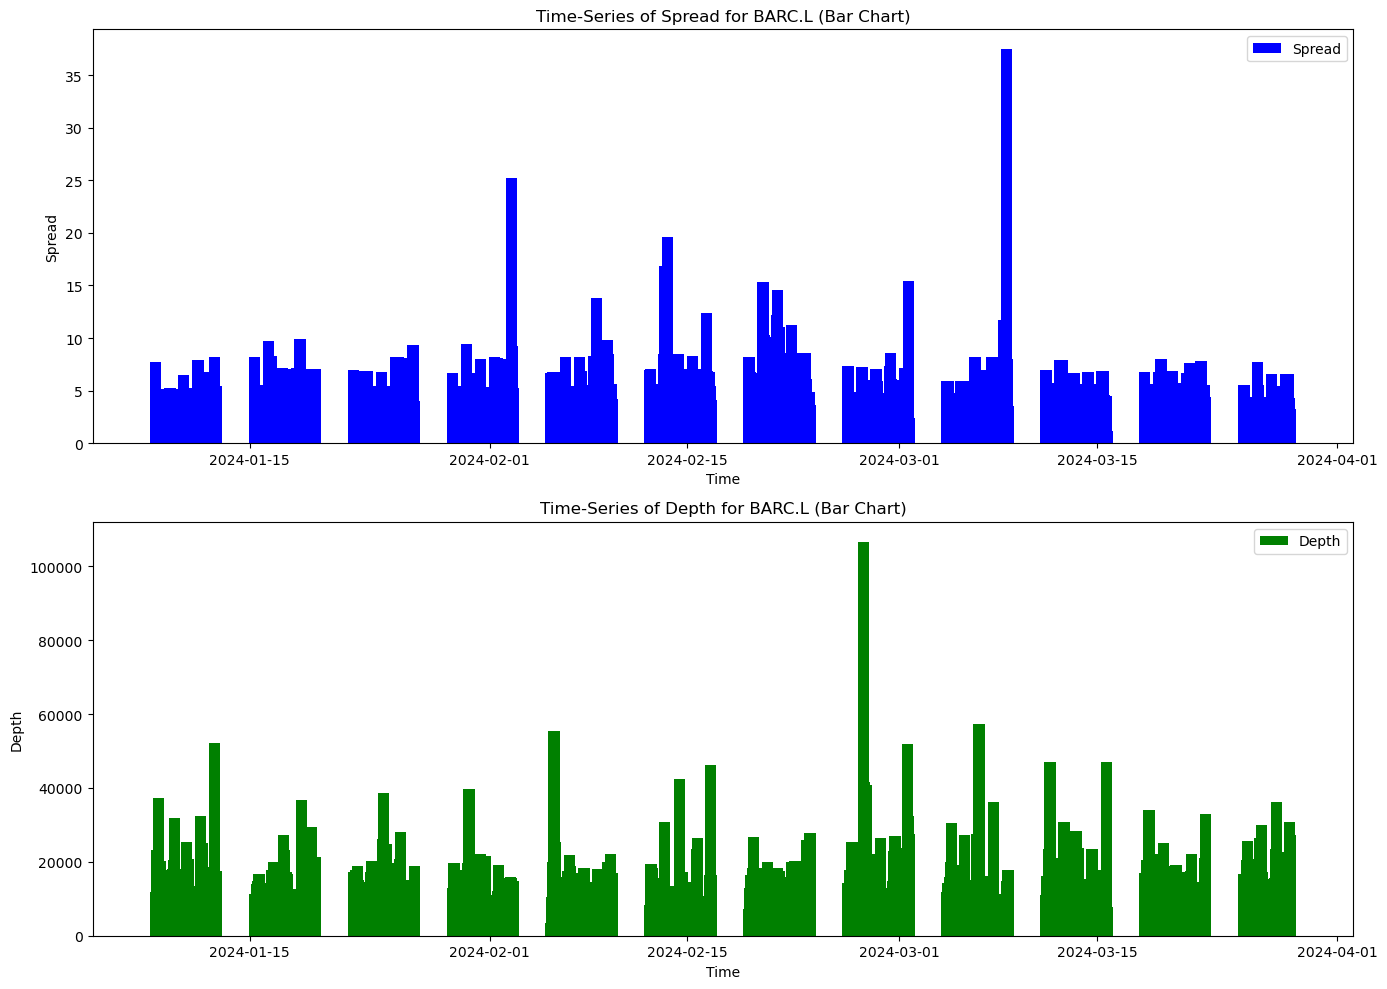

Spread Summary Statistics for BARC.L:
count    28949.000000
mean         3.543646
std          1.349981
min          1.078574
25%          2.661698
50%          3.478463
75%          4.174494
max         37.470726
Name: Spread, dtype: float64

Depth Summary Statistics for BARC.L:
count     28949.000000
mean       5856.525372
std        3762.027390
min          21.500000
25%        3372.500000
50%        5099.000000
75%        7433.000000
max      106717.000000
Name: Depth, dtype: float64




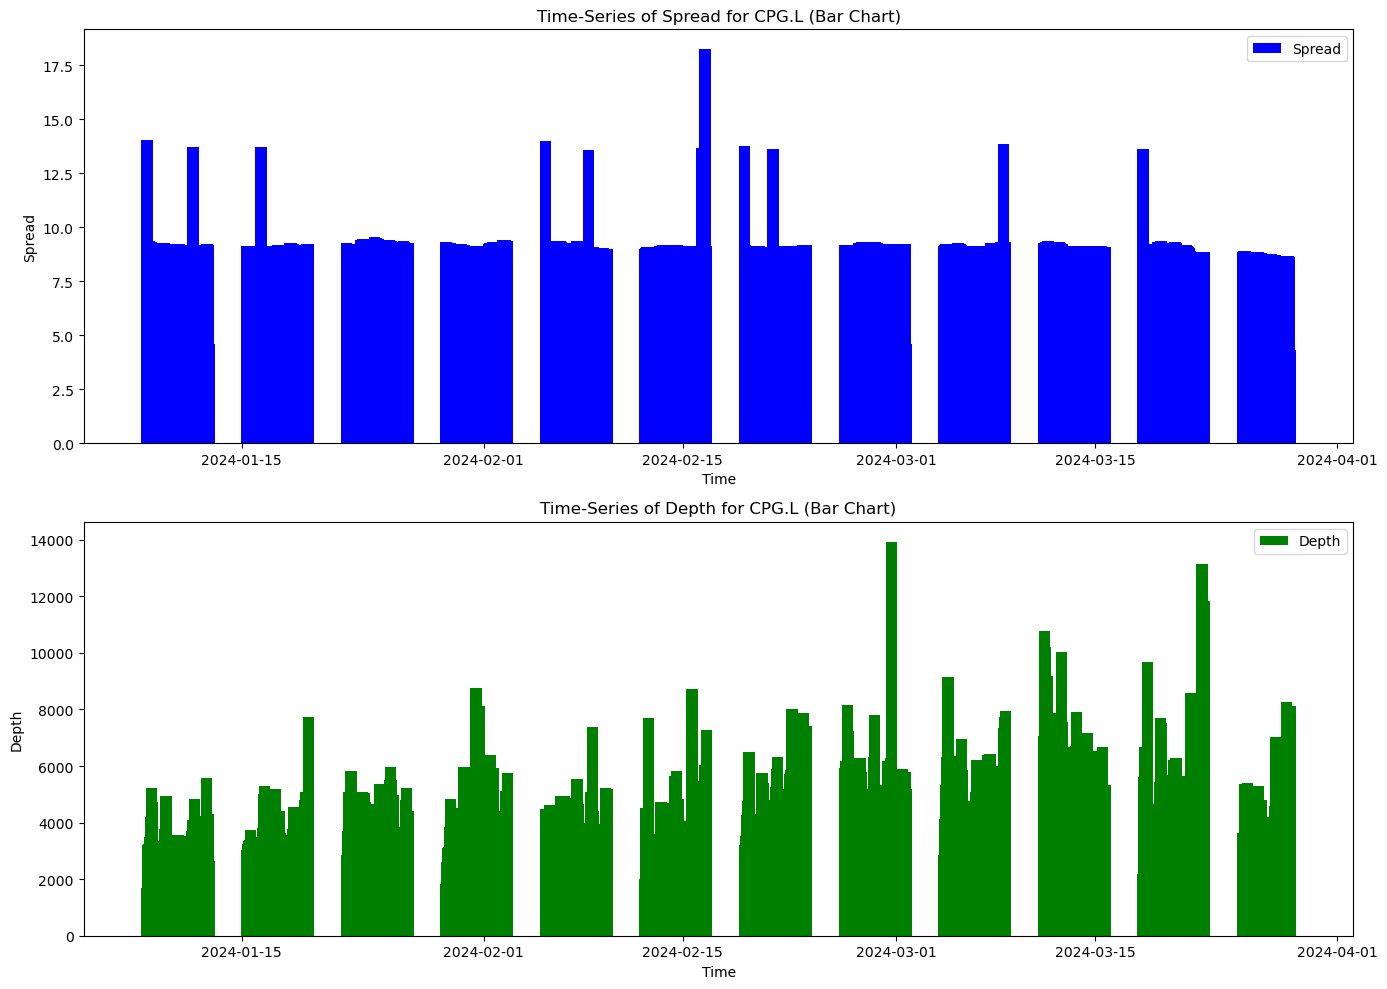

Spread Summary Statistics for CPG.L:
count    28915.000000
mean         6.013950
std          2.132908
min          4.300151
25%          4.563085
50%          4.624277
75%          9.086779
max         18.256504
Name: Spread, dtype: float64

Depth Summary Statistics for CPG.L:
count    28915.000000
mean      2423.982829
std       1274.935823
min        109.000000
25%       1493.750000
50%       2182.000000
75%       3058.500000
max      13937.000000
Name: Depth, dtype: float64




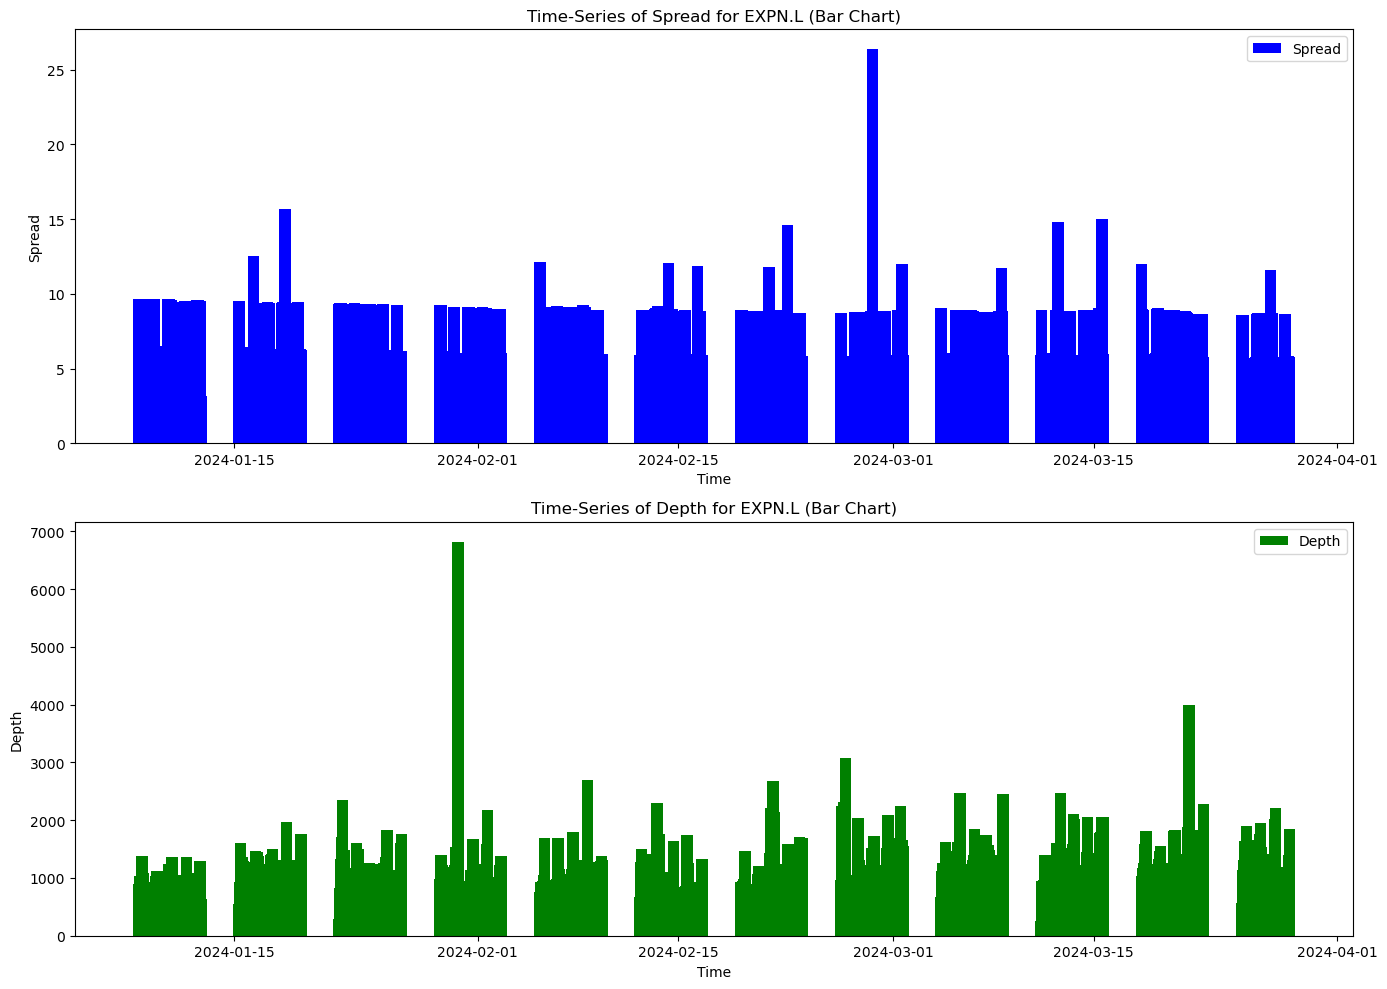

Spread Summary Statistics for EXPN.L:
count    28938.000000
mean         4.912640
std          1.646084
min          2.836477
25%          3.026176
50%          5.866823
75%          6.029545
max         26.381357
Name: Spread, dtype: float64

Depth Summary Statistics for EXPN.L:
count    28938.000000
mean       544.702364
std        341.320236
min          7.000000
25%        293.000000
50%        500.000000
75%        723.500000
max       6825.000000
Name: Depth, dtype: float64




In [7]:
# validating uniqueness of the stock column for plotting
stocks = dfp1['Stock'].unique()

# Looking for each unique stock
for stock in stocks:
    stock_data = dfp1[dfp1['Stock'] == stock]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plotting Spread
    axs[0].bar(stock_data.index, stock_data['Spread'], label='Spread', color='blue')
    axs[0].set_title(f'Time-Series of Spread for {stock} (Bar Chart)')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Spread')
    axs[0].legend()

    # Plotting Depth
    axs[1].bar(stock_data.index, stock_data['Depth'], label='Depth', color='green')
    axs[1].set_title(f'Time-Series of Depth for {stock} (Bar Chart)')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Depth')
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    
    # Defining summary statistics and printing them
    spread_summary = stock_data['Spread'].describe()
    depth_summary = stock_data['Depth'].describe()
    
    print(f"Spread Summary Statistics for {stock}:")
    print(spread_summary)
    
    print(f"\nDepth Summary Statistics for {stock}:")
    print(depth_summary)
    print("\n" + "="*50 + "\n")

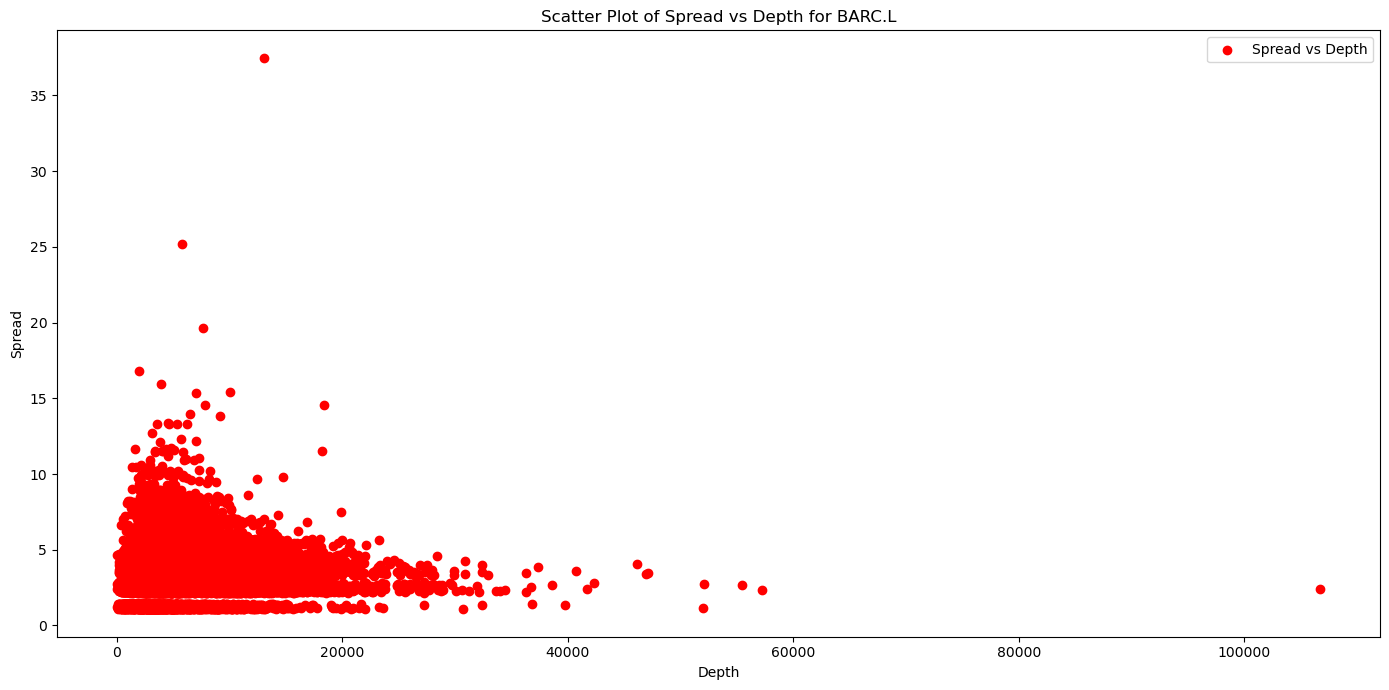

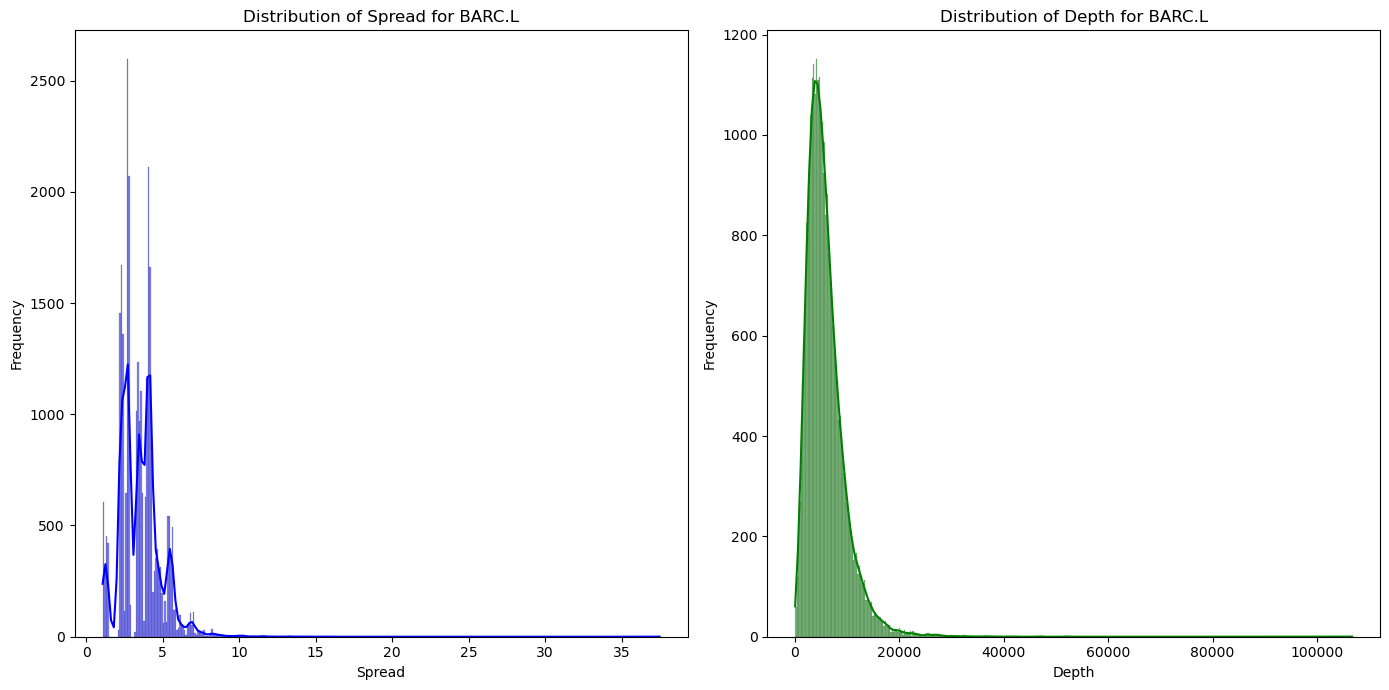

OLS Regression Results for BARC.L:
                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     362.3
Date:                Thu, 30 May 2024   Prob (F-statistic):           2.70e-80
Time:                        11:09:02   Log-Likelihood:                -49584.
No. Observations:               28949   AIC:                         9.917e+04
Df Residuals:                   28947   BIC:                         9.919e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.

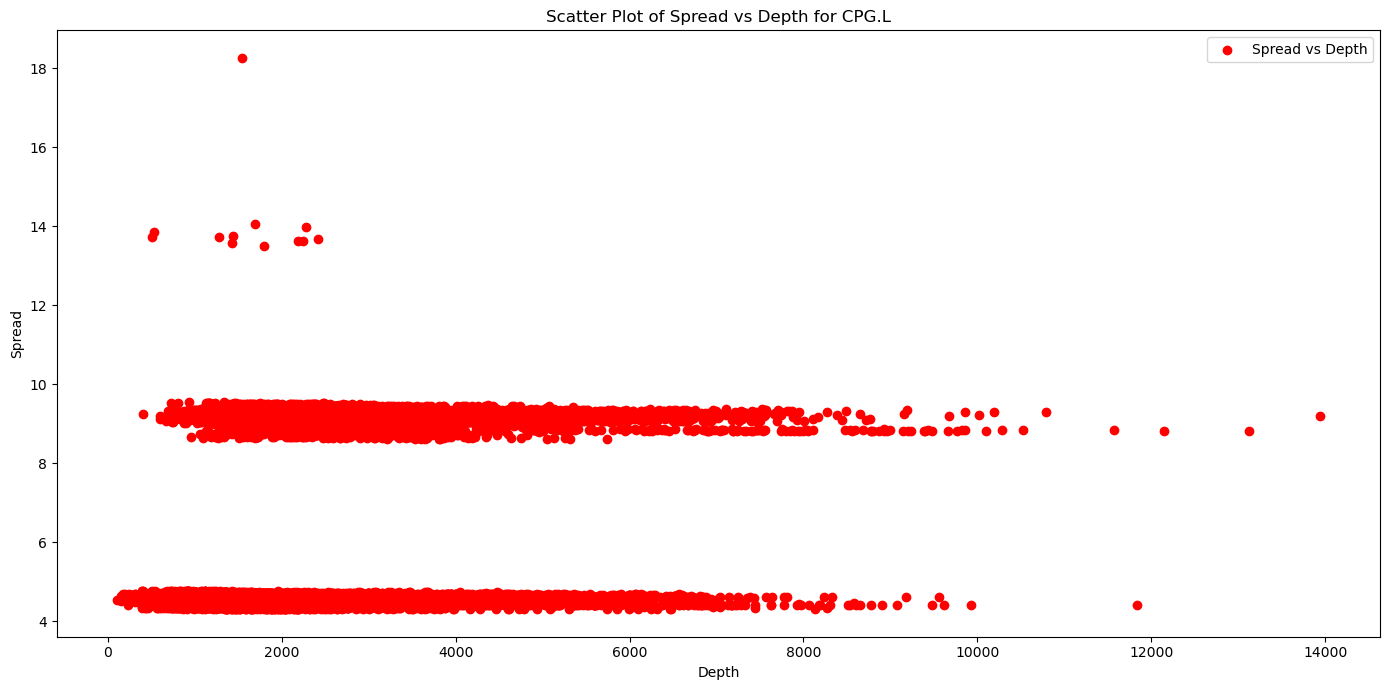

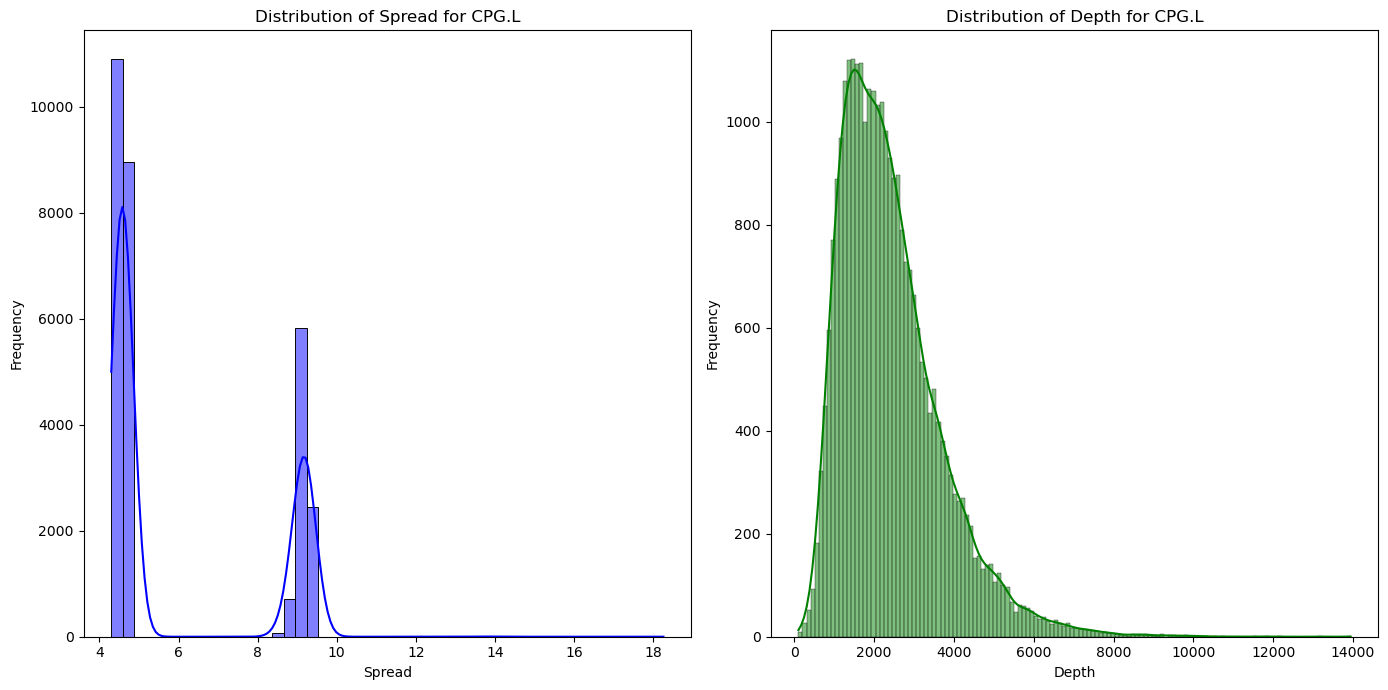

OLS Regression Results for CPG.L:
                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5214.
Date:                Thu, 30 May 2024   Prob (F-statistic):               0.00
Time:                        11:09:05   Log-Likelihood:                -60534.
No. Observations:               28915   AIC:                         1.211e+05
Df Residuals:                   28913   BIC:                         1.211e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4

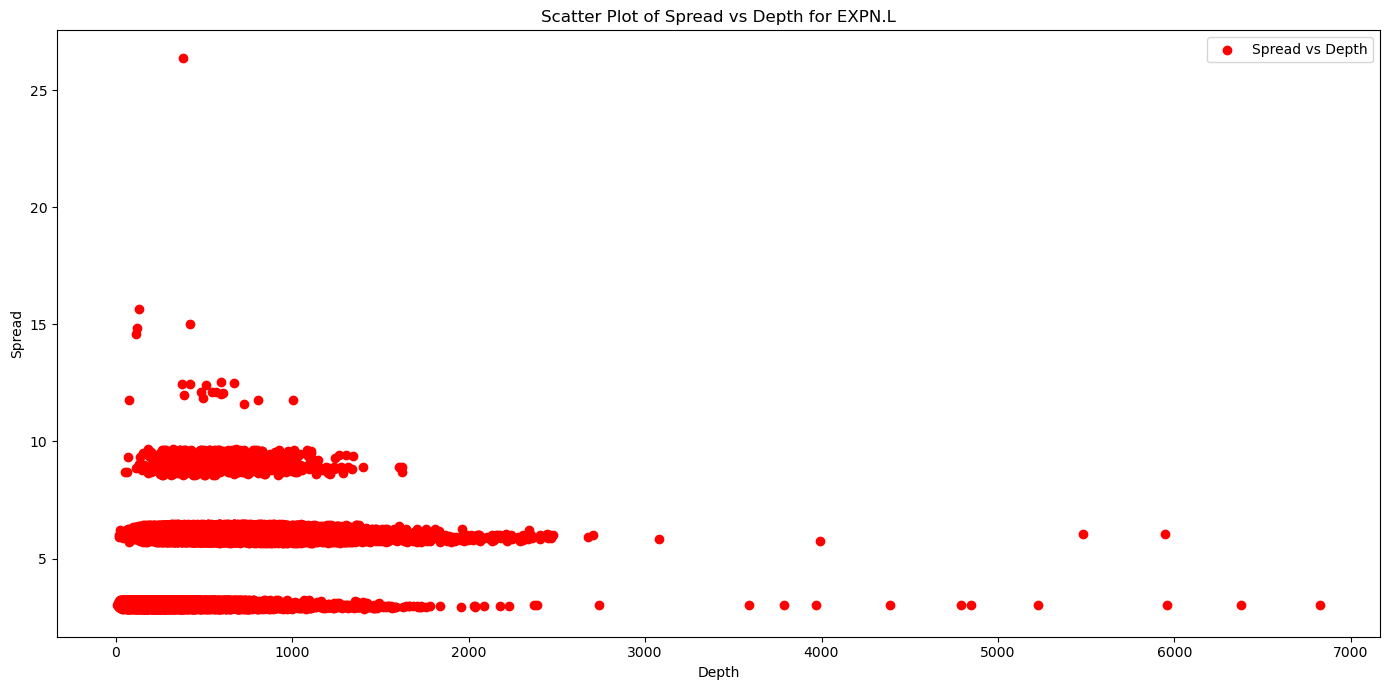

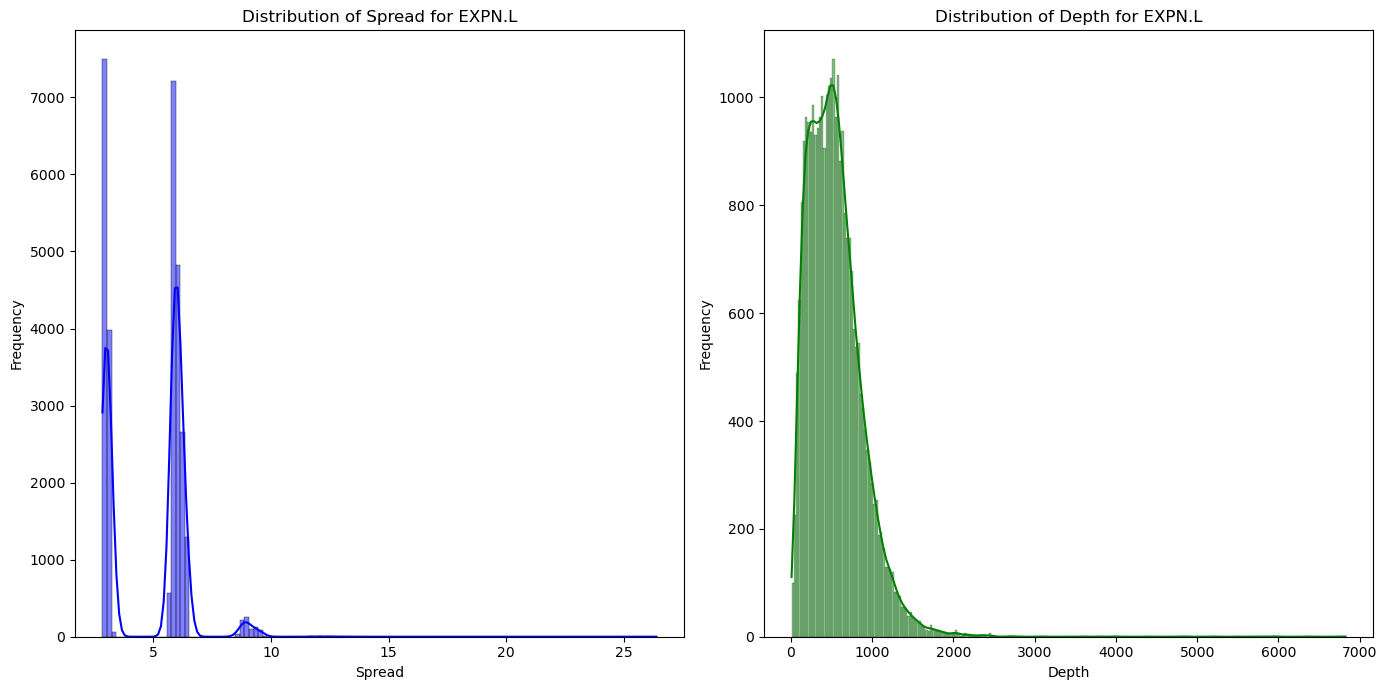

OLS Regression Results for EXPN.L:
                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     6059.
Date:                Thu, 30 May 2024   Prob (F-statistic):               0.00
Time:                        11:09:07   Log-Likelihood:                -52732.
No. Observations:               28938   AIC:                         1.055e+05
Df Residuals:                   28936   BIC:                         1.055e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.

In [8]:
#  need to take outliers away so i do the below to check first

# Plotting the variables in a scatterplot to see if there is any correlation (i would assume negative)
# Looking at the distribution with KDE 
# Computing the OLS to see relationship of the two variables

for stock in stocks:
    stock_data = dfp1[dfp1['Stock'] == stock]
    
    # Scatter plots
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.scatter(stock_data['Depth'], stock_data['Spread'], label='Spread vs Depth', color='red')
    ax.set_title(f'Scatter Plot of Spread vs Depth for {stock}')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Spread')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Distribution plots 
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    sns.histplot(stock_data['Spread'], kde=True, ax=axs[0], color='blue')
    axs[0].set_title(f'Distribution of Spread for {stock}')
    axs[0].set_xlabel('Spread')
    axs[0].set_ylabel('Frequency')
    
    sns.histplot(stock_data['Depth'], kde=True, ax=axs[1], color='green')
    axs[1].set_title(f'Distribution of Depth for {stock}')
    axs[1].set_xlabel('Depth')
    axs[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Running OLS regression
    X = stock_data['Depth']
    y = stock_data['Spread']
    X = sm.add_constant(X)  # adding a constant

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    print(f"OLS Regression Results for {stock}:")
    print(model.summary())
    print("\n" + "="*50 + "\n")

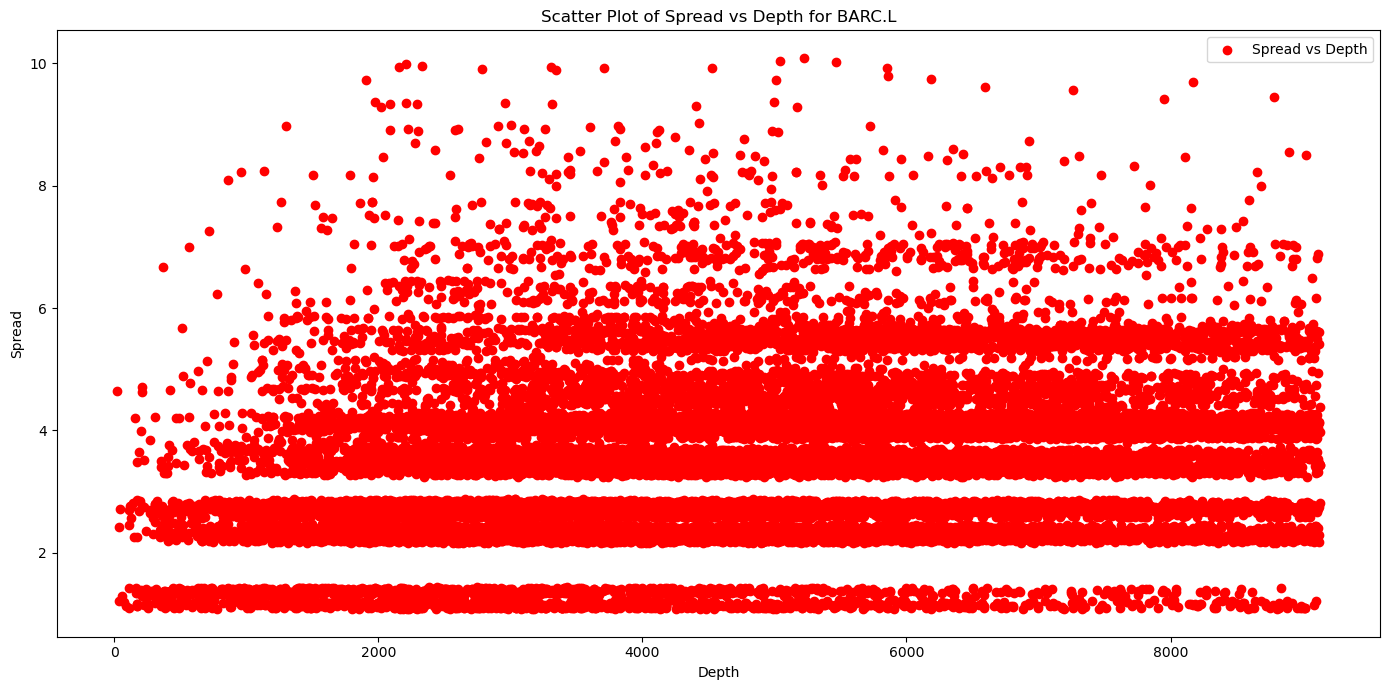

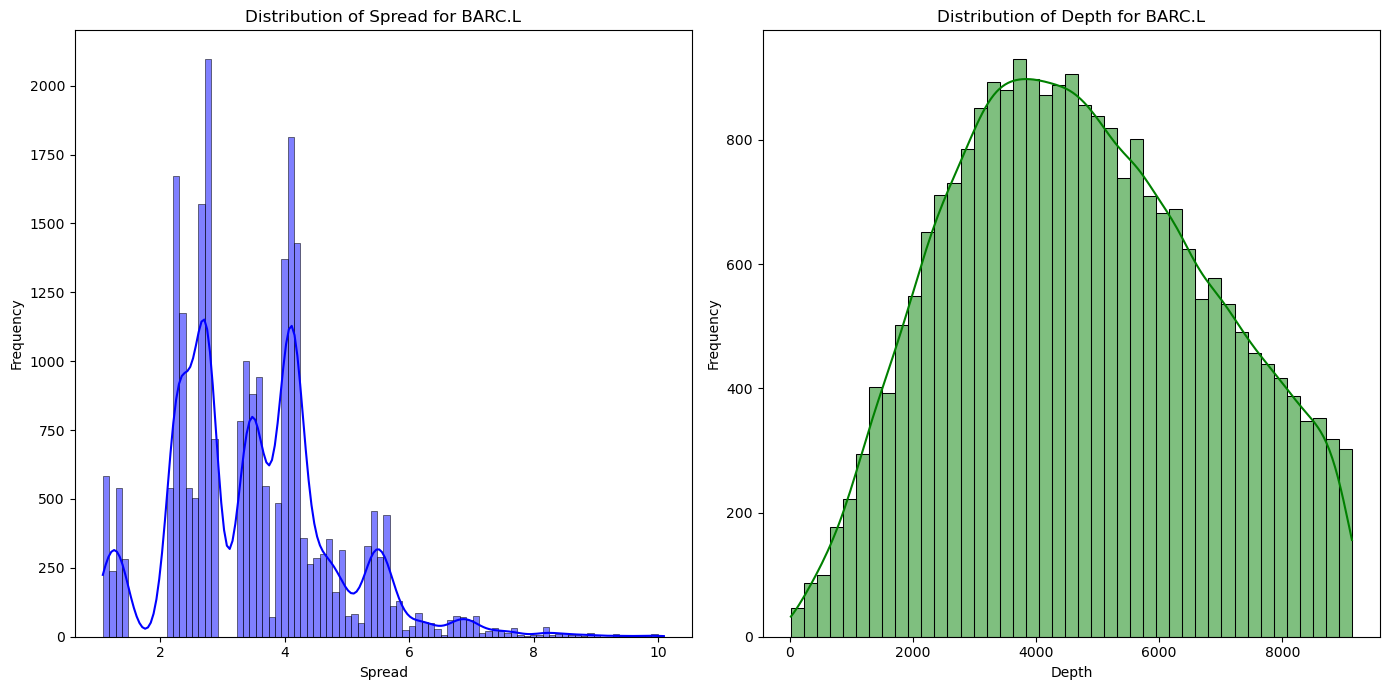

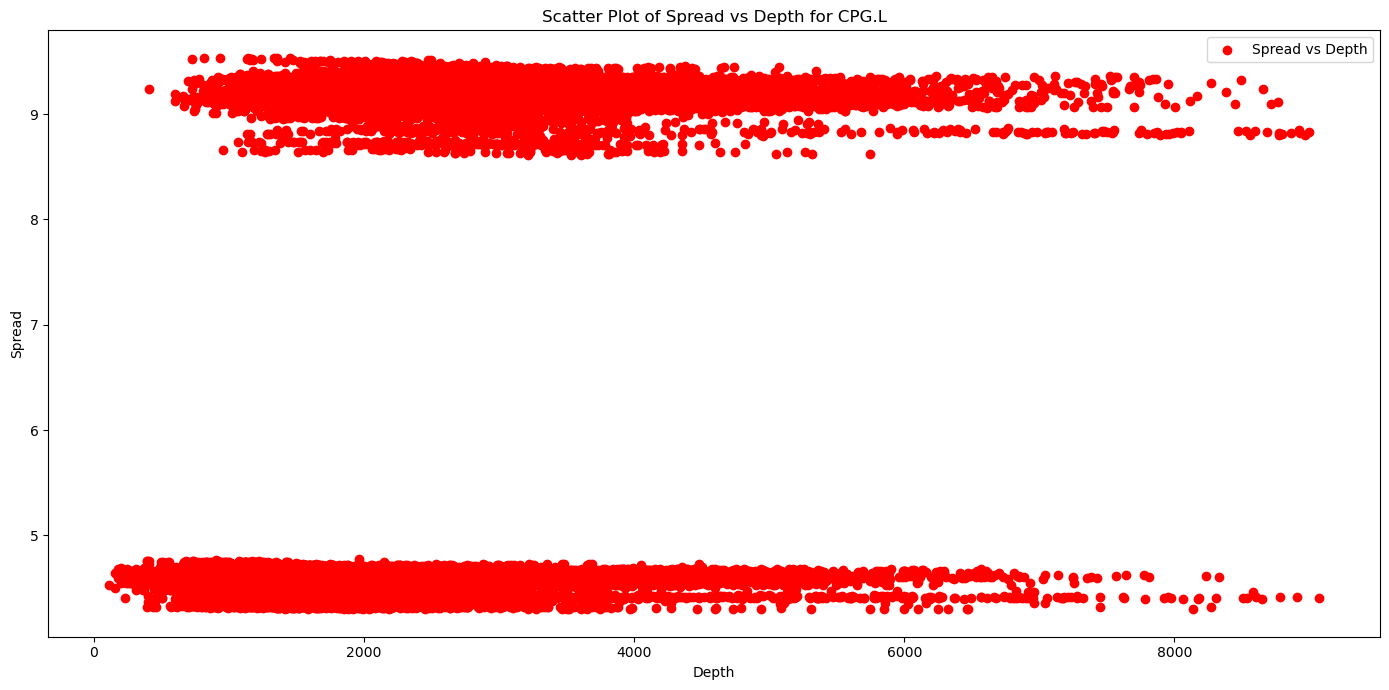

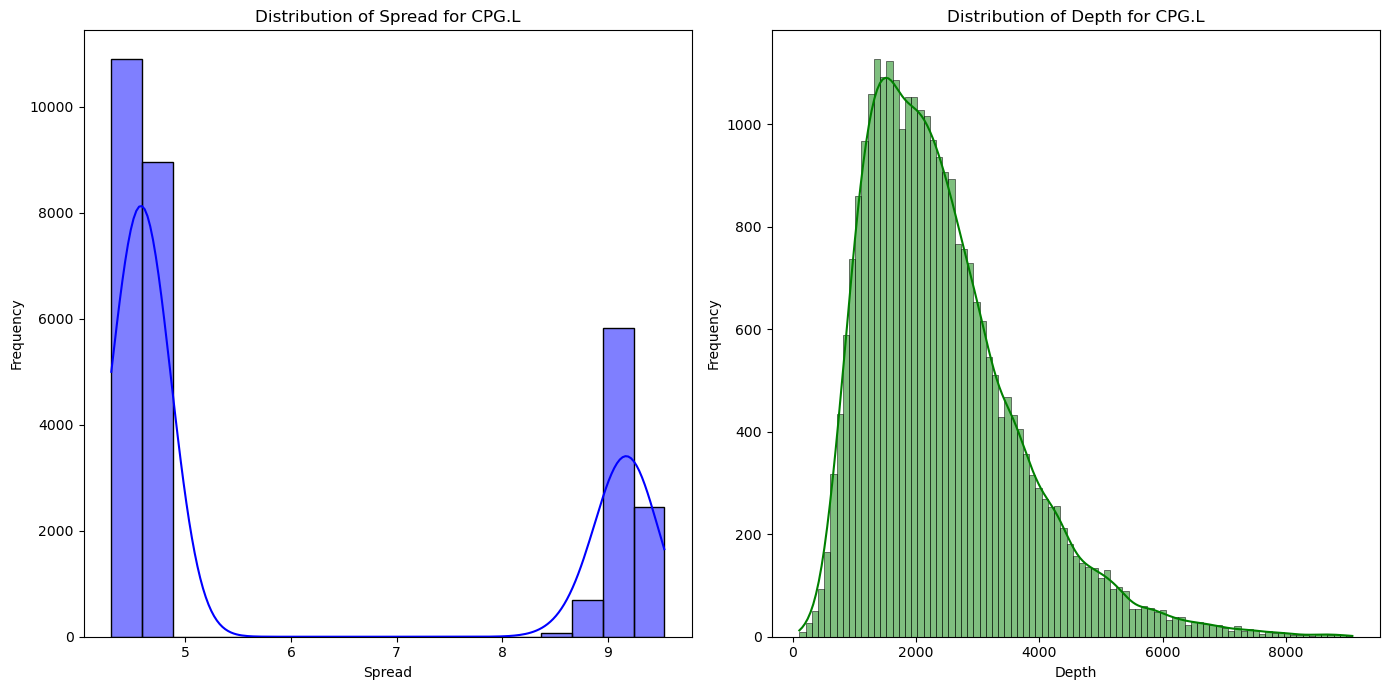

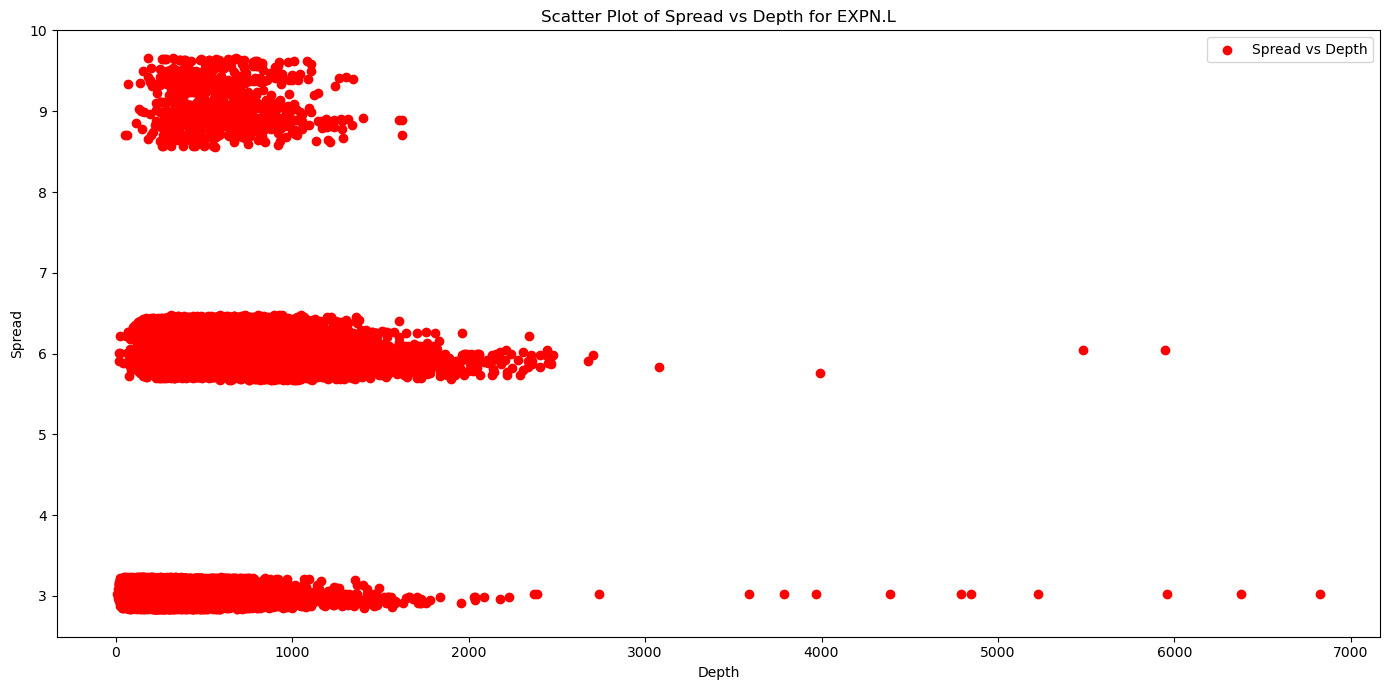

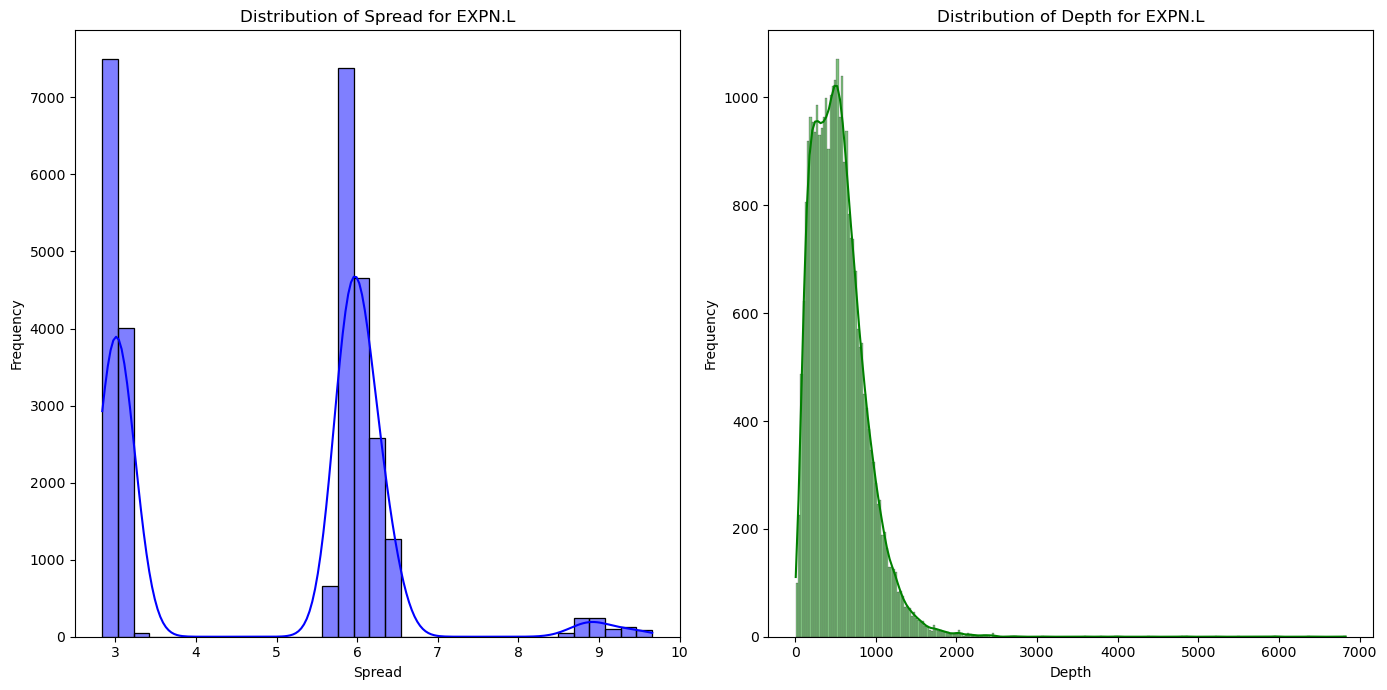

In [9]:
# There are some outliers where Spread is higher than usual, 
# but these are rare compared to the main clusters so we can exclude them

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing the outliers based on function above
dfp1 = remove_outliers(dfp1, 'Spread')
dfp1 = remove_outliers(dfp1, 'Depth')

# lets plot again having excluded outliers
for stock in stocks:
    stock_data = dfp1[dfp1['Stock'] == stock]
    
    # Scatter plots
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.scatter(stock_data['Depth'], stock_data['Spread'], label='Spread vs Depth', color='red')
    ax.set_title(f'Scatter Plot of Spread vs Depth for {stock}')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Spread')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Distribution plots 
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    sns.histplot(stock_data['Spread'], kde=True, ax=axs[0], color='blue')
    axs[0].set_title(f'Distribution of Spread for {stock}')
    axs[0].set_xlabel('Spread')
    axs[0].set_ylabel('Frequency')
    
    sns.histplot(stock_data['Depth'], kde=True, ax=axs[1], color='green')
    axs[1].set_title(f'Distribution of Depth for {stock}')
    axs[1].set_xlabel('Depth')
    axs[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

If the histogram of the spread shows a concentration around lower values (e.g., close to 1 or 2), it suggests that EXPN.L generally has a tight spread, implying good liquidity.
If the spread has frequent outliers or higher values, it indicates periods of lower liquidity.
Depth:
A histogram with higher values of depth implies better liquidity. If EXPN.L shows a distribution with a substantial number of shares at each price level, it indicates robust market depth.

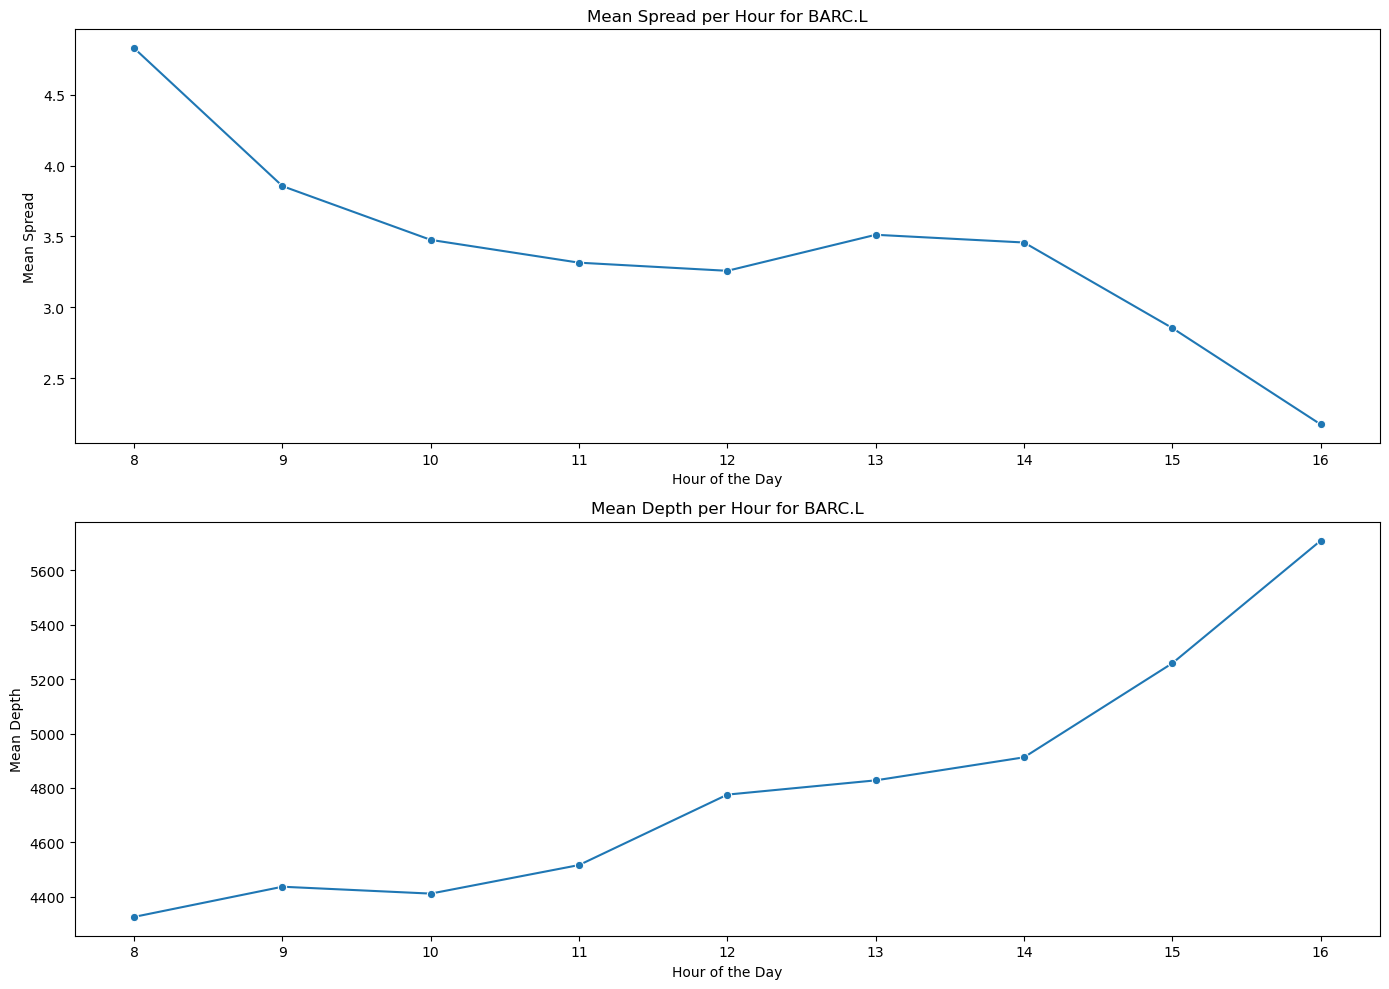

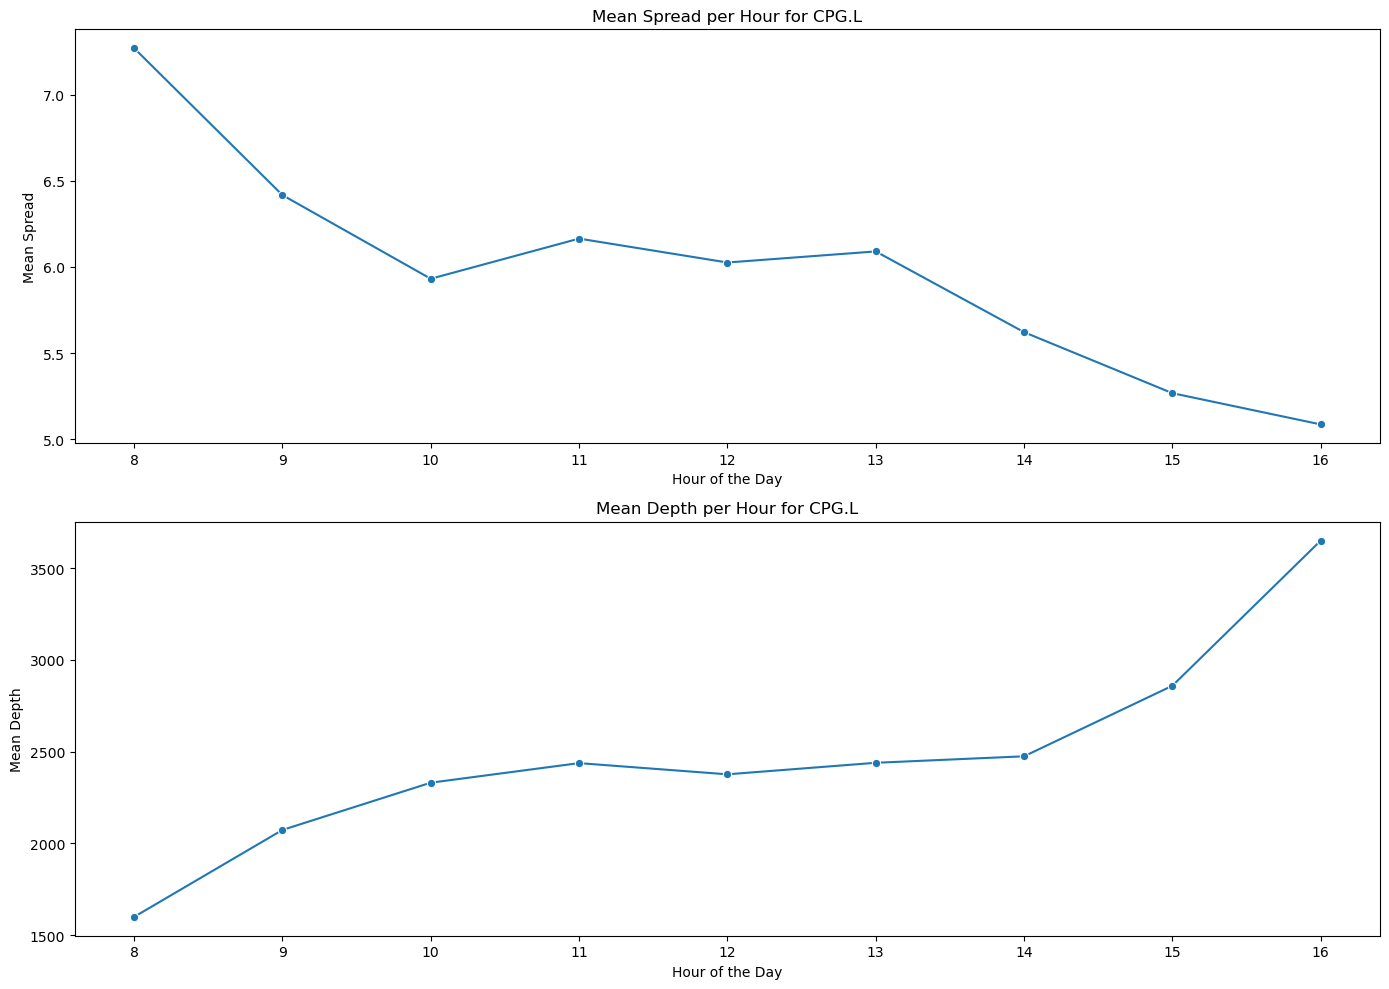

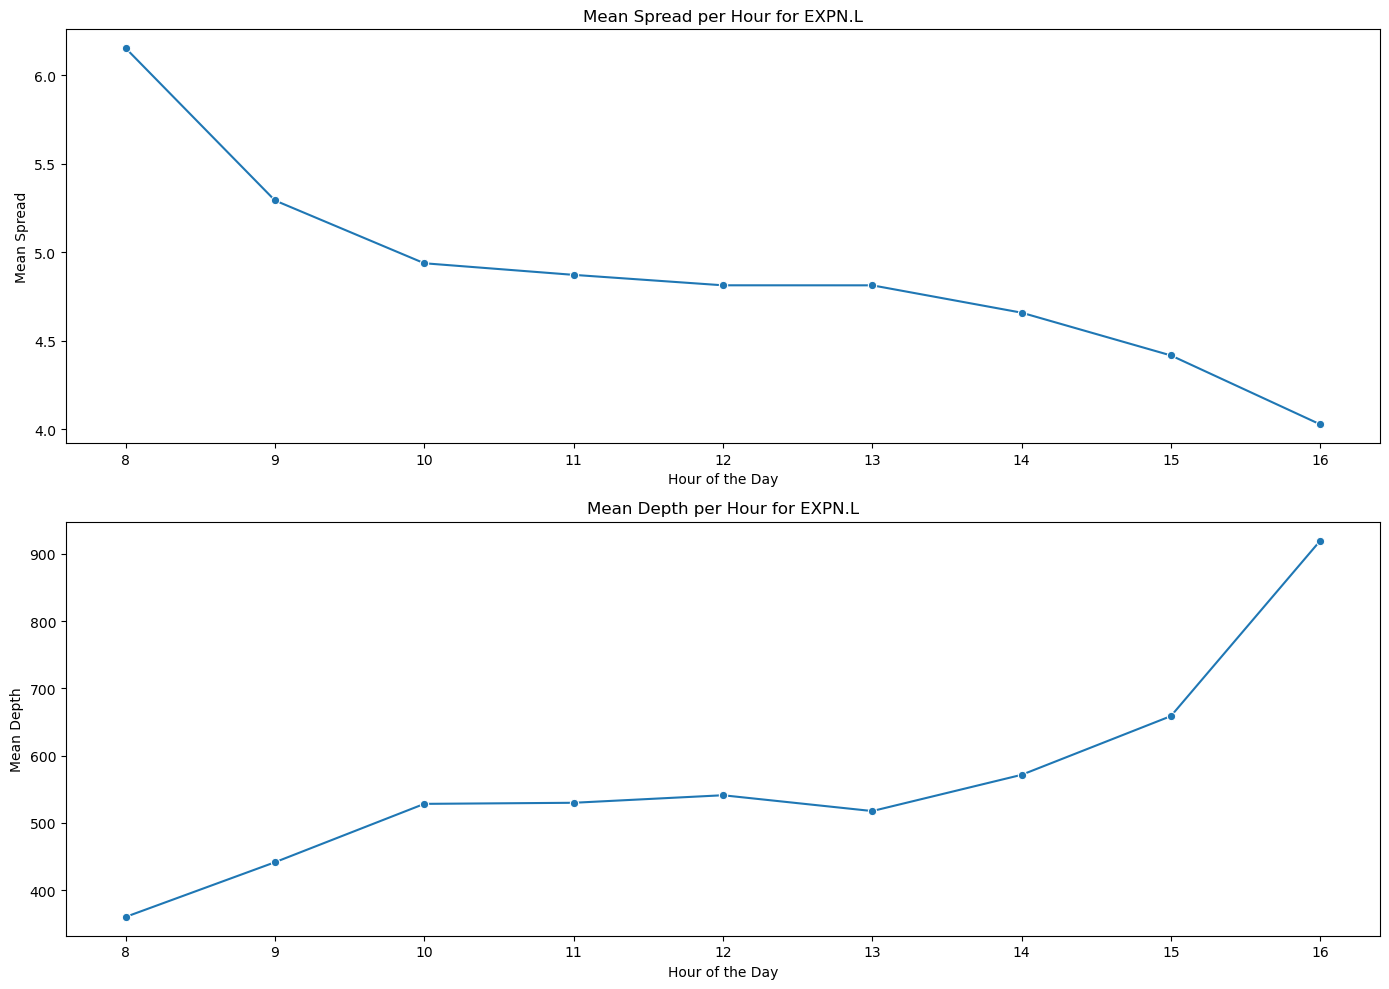

In [10]:
# Add an hour column for aggregation
dfp1['Hour'] = dfp1.index.hour

# i am using a simple mean here we can use a geomean or a wmean if we need or want
for stock in stocks:
    stock_data = dfp1[dfp1['Stock'] == stock]
    
    hourly_means = stock_data.groupby('Hour').agg({
        'Spread': 'mean',
        'Depth': 'mean'
    }).reset_index()
    
    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot mean spread per hour
    sns.lineplot(data=hourly_means, x='Hour', y='Spread', ax=axs[0], marker='o')
    axs[0].set_title(f'Mean Spread per Hour for {stock}')
    axs[0].set_xlabel('Hour of the Day')
    axs[0].set_ylabel('Mean Spread')

    # Plot mean depth per hour
    sns.lineplot(data=hourly_means, x='Hour', y='Depth', ax=axs[1], marker='o')
    axs[1].set_title(f'Mean Depth per Hour for {stock}')
    axs[1].set_xlabel('Hour of the Day')
    axs[1].set_ylabel('Mean Depth')

    plt.tight_layout()
    plt.show()

In [11]:
# Filtering for a specific stock (EXPN.L)
dfp1expn = dfp1[dfp1['Stock'] == 'EXPN.L']

# Defining the day column for the calculations
dfp1expn['Day'] = dfp1expn.index.date

# Calculate daily averages and volatility
daily_stats = dfp1expn.groupby('Day').agg({
    'Spread': 'mean',
    'Depth': 'mean',
    'Midquote Returns': lambda x: x.abs().mean()
}).rename(columns={'Midquote Returns': 'Midquote Volatility'})

dfp1expn

C:\Users\local_adfy299\Temp\ipykernel_7580\4259402410.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp1expn['Day'] = dfp1expn.index.date


,Stock,Last,Volume,No. Trades,Close Bid,Close Ask,Close Bid Size,Close Ask Size,Midquote,Midquote Returns,Spread,Depth,Hour,Day
datereformat,,,,,,,,,,,,,,
2024-01-08 08:15:00,EXPN.L,NaN,NaN,NaN,3105.0,3108.0,4.0,364.0,3106.5,1.609788,9.657170,184.0,8,2024-01-08
2024-01-08 08:16:00,EXPN.L,3105.000,1069.0,13.0,3102.0,3104.0,106.0,331.0,3103.0,-11.266699,6.445375,218.5,8,2024-01-08
2024-01-08 08:17:00,EXPN.L,3111.000,1124.0,14.0,3110.0,3113.0,302.0,216.0,3111.5,27.392846,9.641652,259.0,8,2024-01-08
2024-01-08 08:18:00,EXPN.L,3110.000,1038.0,12.0,3108.0,3111.0,317.0,336.0,3109.5,-6.427768,9.647853,326.5,8,2024-01-08
2024-01-08 08:19:00,EXPN.L,NaN,NaN,NaN,3108.0,3109.0,3.0,199.0,3108.5,-3.215951,3.216986,101.0,8,2024-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28 16:21:00,EXPN.L,3464.000,326.0,7.0,3464.0,3465.0,1054.0,625.0,3464.5,1.443418,2.886419,839.5,16,2024-03-28
2024-03-28 16:22:00,EXPN.L,3463.000,1284.0,7.0,3462.0,3464.0,1624.0,1918.0,3463.0,-4.329629,5.775339,1771.0,16,2024-03-28
2024-03-28 16:23:00,EXPN.L,3462.000,430.0,8.0,3461.0,3463.0,2113.0,1424.0,3462.0,-2.887670,5.777008,1768.5,16,2024-03-28


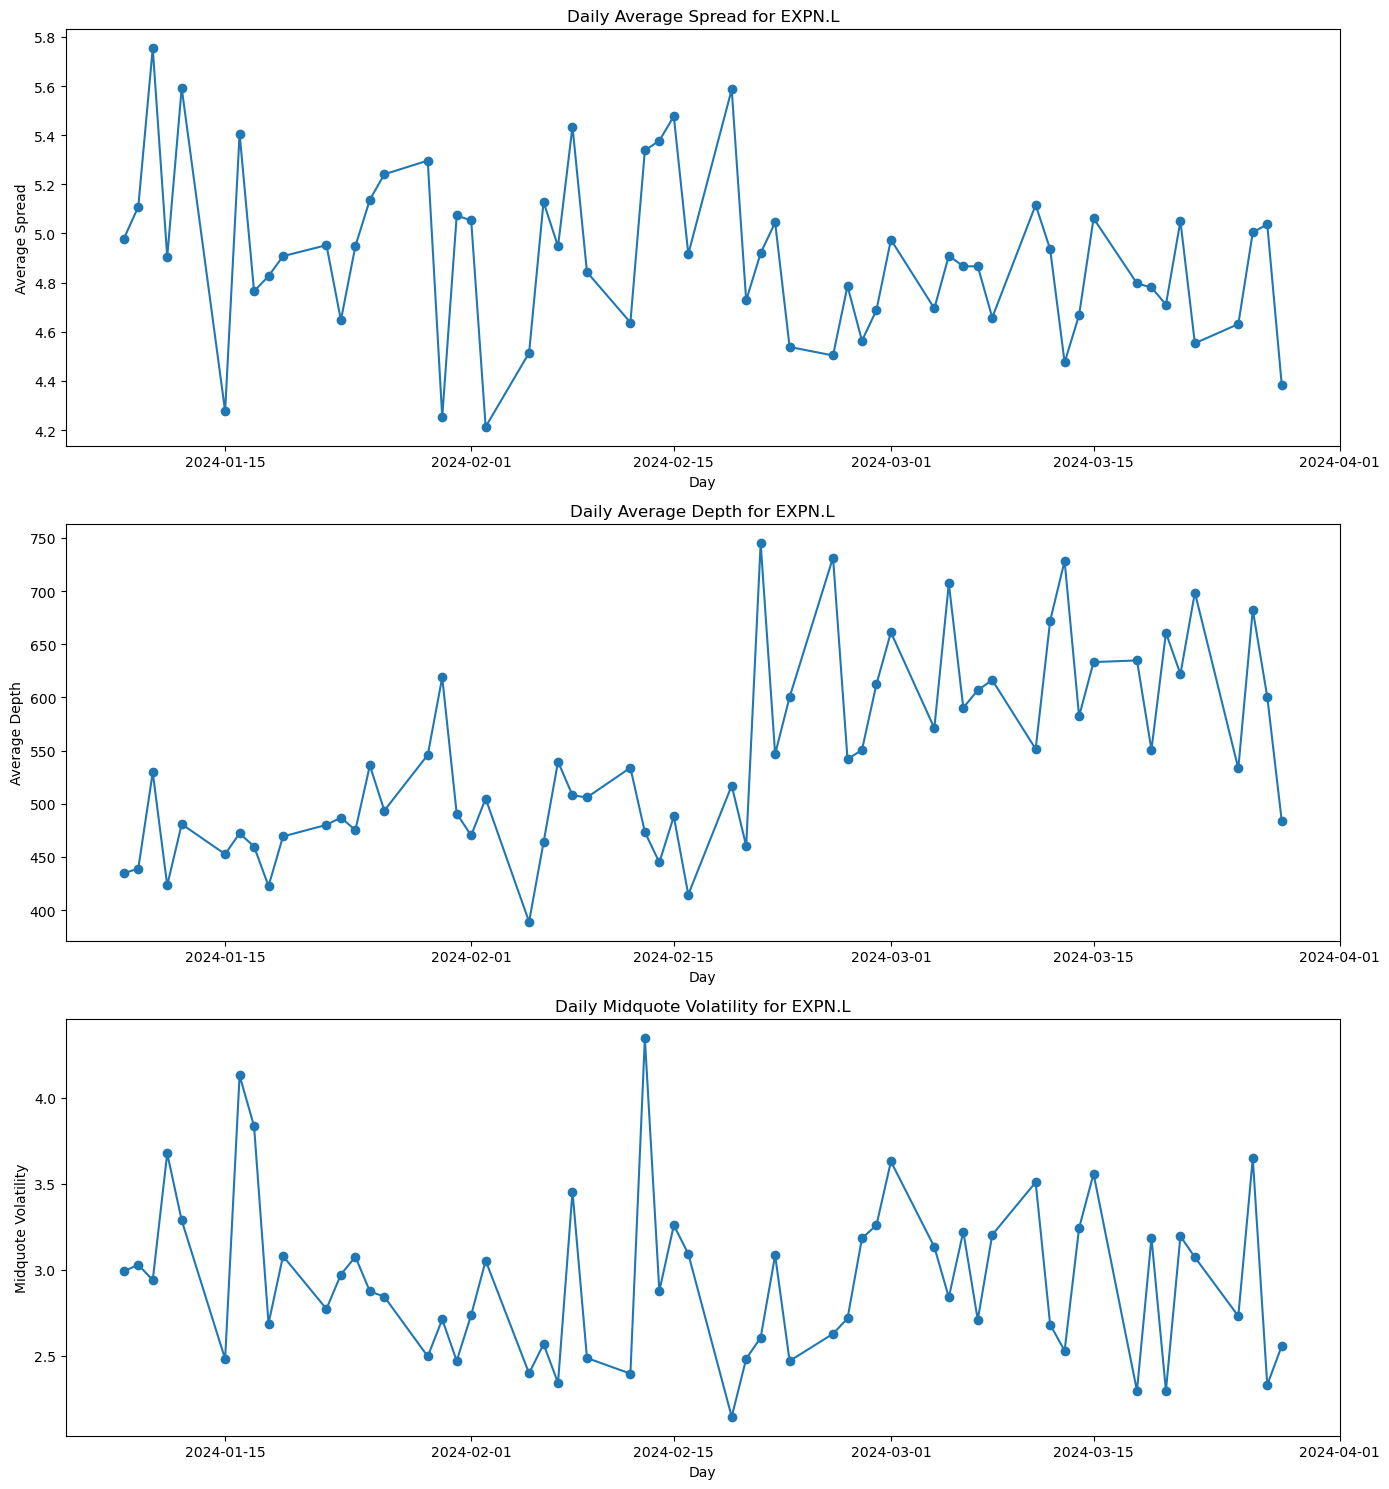

In [12]:
# Setting up average plots (i used standard mean in this case but we can use geomean too)
fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Spread plot
axs[0].plot(daily_stats.index, daily_stats['Spread'], marker='o')
axs[0].set_title('Daily Average Spread for EXPN.L')
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Average Spread')

# Depth Plot
axs[1].plot(daily_stats.index, daily_stats['Depth'], marker='o')
axs[1].set_title('Daily Average Depth for EXPN.L')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Average Depth')

# Midquote Volatility plot
axs[2].plot(daily_stats.index, daily_stats['Midquote Volatility'], marker='o')
axs[2].set_title('Daily Midquote Volatility for EXPN.L')
axs[2].set_xlabel('Day')
axs[2].set_ylabel('Midquote Volatility')

plt.tight_layout()
plt.show()

In [13]:
# Step 1: Correlation Analysis
correlation = daily_stats['Spread'].corr(daily_stats['Depth'])
print(f"Correlation between daily average spreads and depth: {correlation}")

Correlation between daily average spreads and depth: -0.22846228958692968


Regression Results of Spread on Volatility:
                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     4.477
Date:                Thu, 30 May 2024   Prob (F-statistic):             0.0387
Time:                        11:09:55   Log-Likelihood:                -16.654
No. Observations:                  59   AIC:                             37.31
Df Residuals:                      57   BIC:                             41.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

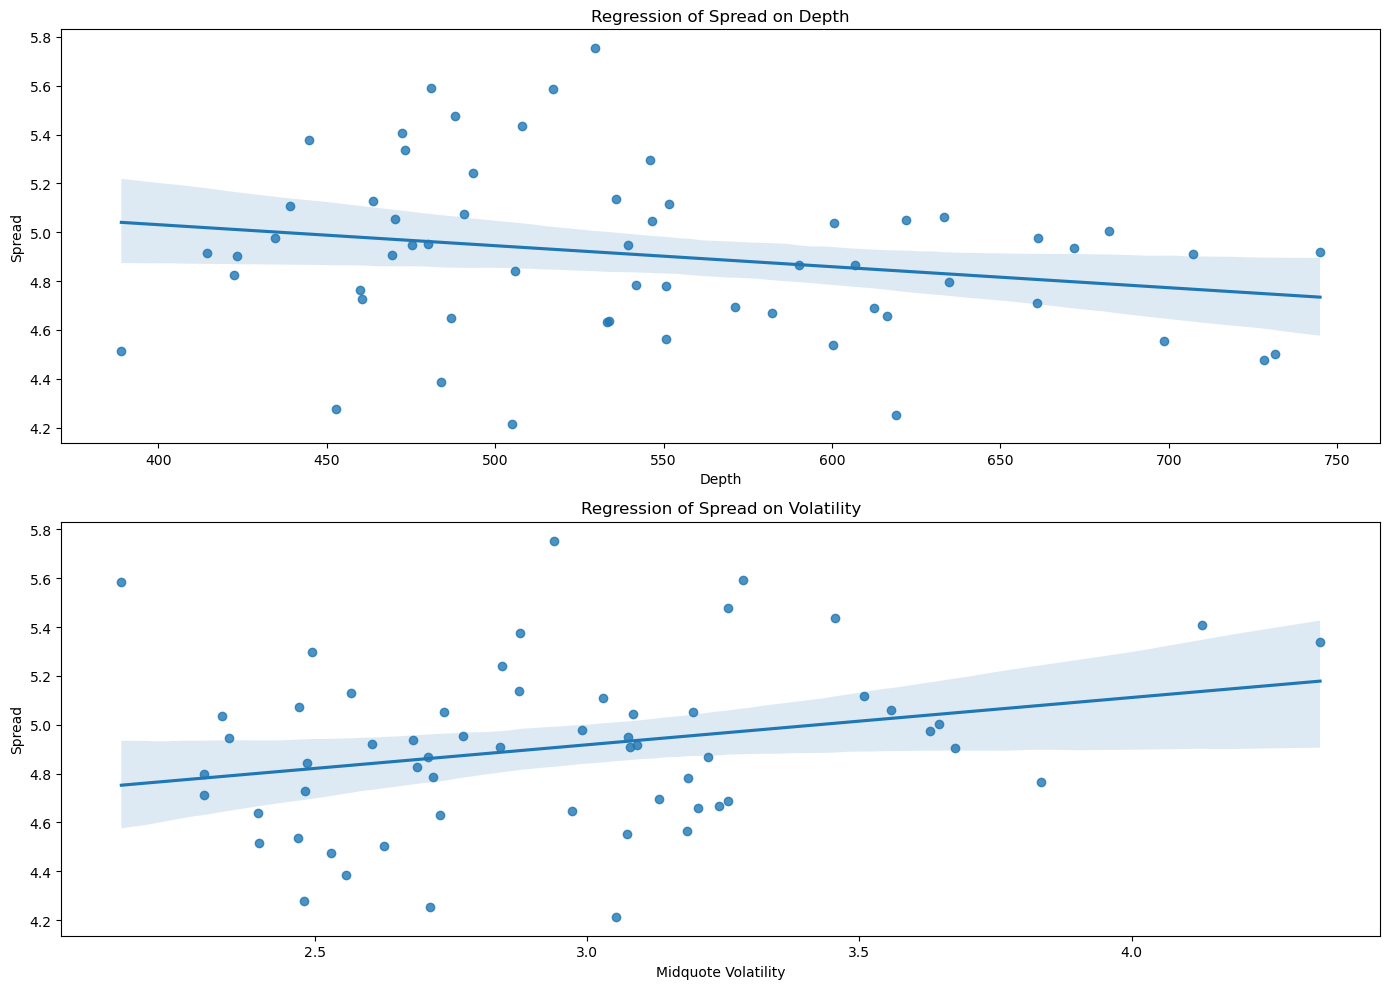

In [14]:
# Running regression for vol
X_volatility = daily_stats['Midquote Volatility']
y_spread = daily_stats['Spread']
X_volatility = sm.add_constant(X_volatility)  # adding a constant

model_volatility = sm.OLS(y_spread, X_volatility).fit()
print("Regression Results of Spread on Volatility:")
print(model_volatility.summary())

# Regression for depth
X_depth = daily_stats['Depth']
X_depth = sm.add_constant(X_depth)  # adding a constant

model_depth = sm.OLS(y_spread, X_depth).fit()
print("Regression Results of Spread on Depth:")
print(model_depth.summary())

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Scatter with line
sns.regplot(x='Depth', y='Spread', data=daily_stats, ax=axs[0])
axs[0].set_title('Regression of Spread on Depth')
axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Spread')

sns.regplot(x='Midquote Volatility', y='Spread', data=daily_stats, ax=axs[1])
axs[1].set_title('Regression of Spread on Volatility')
axs[1].set_xlabel('Midquote Volatility')
axs[1].set_ylabel('Spread')

plt.tight_layout()
plt.show()

# Part 2: Portfolio Analysis

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

/Users/giannixue/anaconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


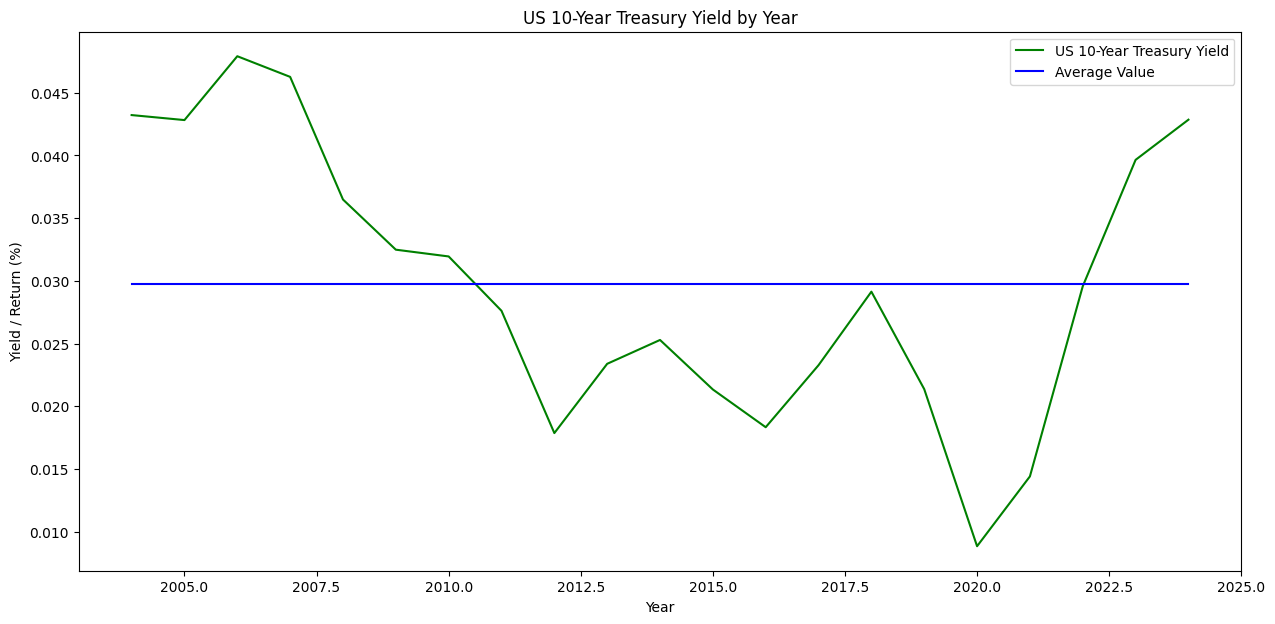

In [2]:
# setting min and max years for the computation below
min_year = 2004
max_year = 2024

# Fetch U.S. 10-year Treasury yield data
# try to use IRX for 3 month for RFR better than 10Y TRB
tnx = yf.Ticker("^TNX")
tnx_data = tnx.history(start=f"{min_year}-05-17", end=f"{max_year}-05-17") # setting limits as in the assumptions
tnx_data['year'] = tnx_data.index.year
tnx_data['Close'] /= 100  # Convert to percentage as yf does not do it for us
yearly_tnx = tnx_data.groupby('year')['Close'].mean()

# set new market data dataframe
market_data = pd.DataFrame({'risk_free_rate': yearly_tnx})

# Finding the average 
market_data['Average'] = market_data['risk_free_rate'].mean()

plt.figure(figsize=(15, 7))
plt.plot(market_data.index, market_data['risk_free_rate'], label='US 10-Year Treasury Yield', color='green')
plt.plot(market_data.index, market_data['Average'], label='Average Value', color='blue')
plt.title('US 10-Year Treasury Yield by Year')
plt.xlabel('Year')
plt.ylabel('Yield / Return (%)')
plt.legend()
plt.grid(False)
plt.show()

In [3]:
average_rfr = market_data['Average']
average_rfr

year
2004    0.029716
2005    0.029716
2006    0.029716
2007    0.029716
2008    0.029716
2009    0.029716
2010    0.029716
2011    0.029716
2012    0.029716
2013    0.029716
2014    0.029716
2015    0.029716
2016    0.029716
2017    0.029716
2018    0.029716
2019    0.029716
2020    0.029716
2021    0.029716
2022    0.029716
2023    0.029716
2024    0.029716
Name: Average, dtype: float64

In [4]:
file_path = "SMM921_pf_data_2024.xlsx"
df = pd.read_excel(file_path)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Calculate monthly returns for each country
returns_df = df.set_index('Date').pct_change().dropna()

# Create the 'world stock market return' as the average return across the 34 countries for each month
World_Market_Return = returns_df.mean(axis=1)

# Set pandas to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the entire DataFrame
print(returns_df)

                 USA        UK  SWITZERLAND     JAPAN    CANADA  AUSTRALIA  \
Date                                                                         
2004-06-17  0.045093  0.061628     0.039071  0.141160  0.055755   0.043901   
2004-07-17 -0.025712 -0.010374    -0.017940 -0.004162  0.031803   0.076134   
2004-08-17 -0.016833 -0.019372    -0.032112 -0.065198 -0.007698  -0.037334   
2004-09-17  0.045549  0.036331     0.011050  0.024958  0.037610   0.026166   
2004-10-17 -0.016380  0.014794    -0.001947  0.006850  0.072110   0.078406   
2004-11-17  0.068796  0.068679     0.120730  0.059864  0.074310   0.112168   
2004-12-17  0.012208  0.026453    -0.009096 -0.002048 -0.018494   0.000741   
2005-01-17 -0.006161 -0.006080     0.009331  0.049980  0.007943   0.029216   
2005-02-17  0.014975  0.062918     0.020110 -0.024223  0.050872   0.070329   
2005-03-17 -0.006382 -0.000960     0.038680  0.030129  0.044246   0.032796   
2005-04-17 -0.037428 -0.022352    -0.023643 -0.053870 -0.077004 

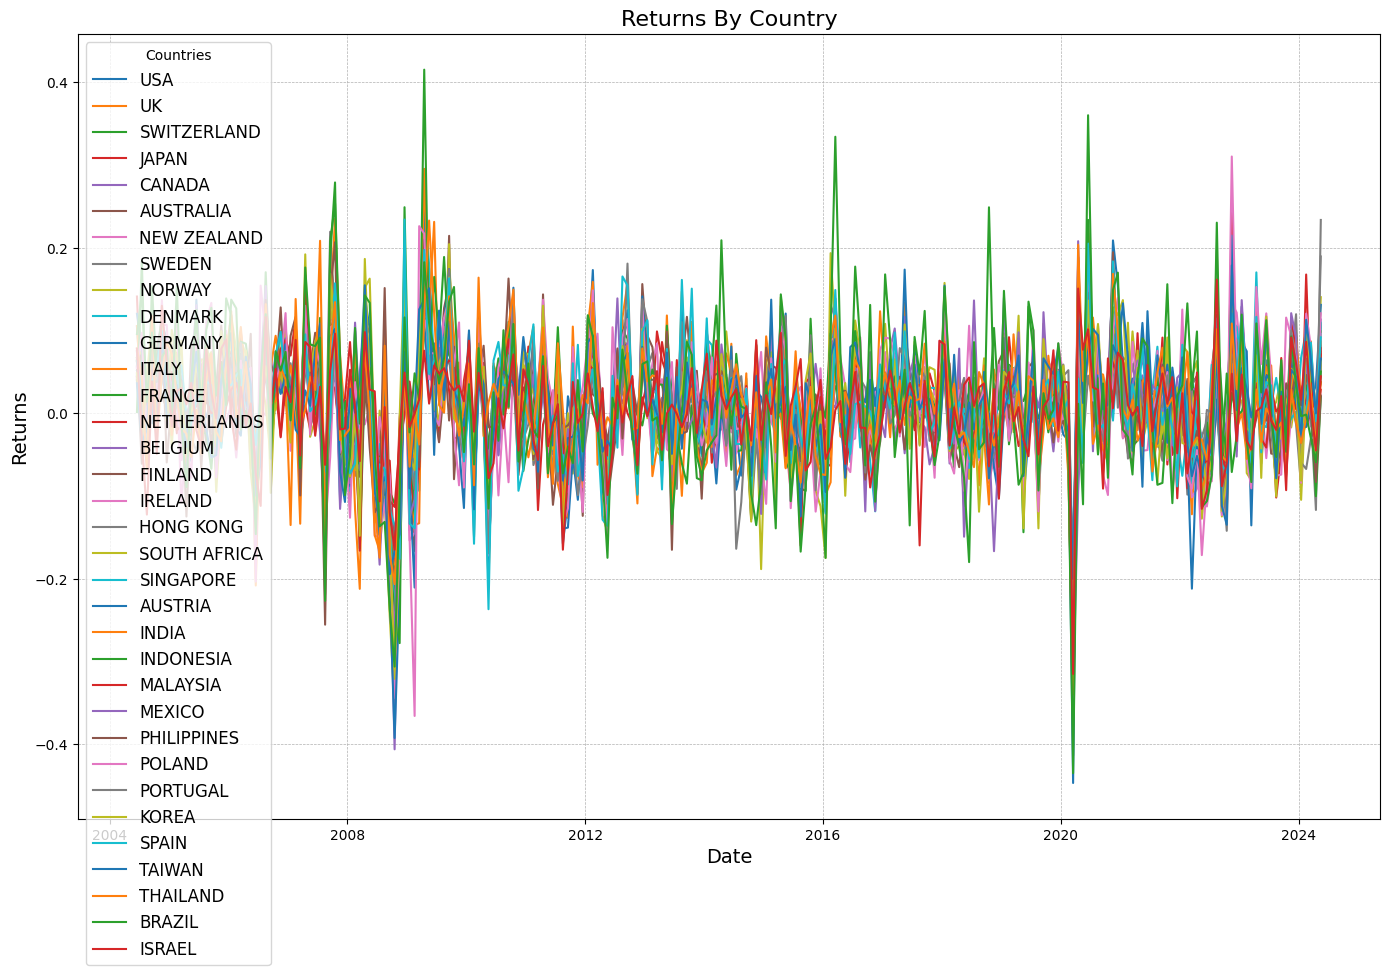

In [5]:
plt.figure(figsize=(14, 10))
for col in returns_df.columns:
    plt.plot(returns_df.index, returns_df[col], label=col)

plt.title('Returns By Country', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)
plt.legend(title='Countries', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

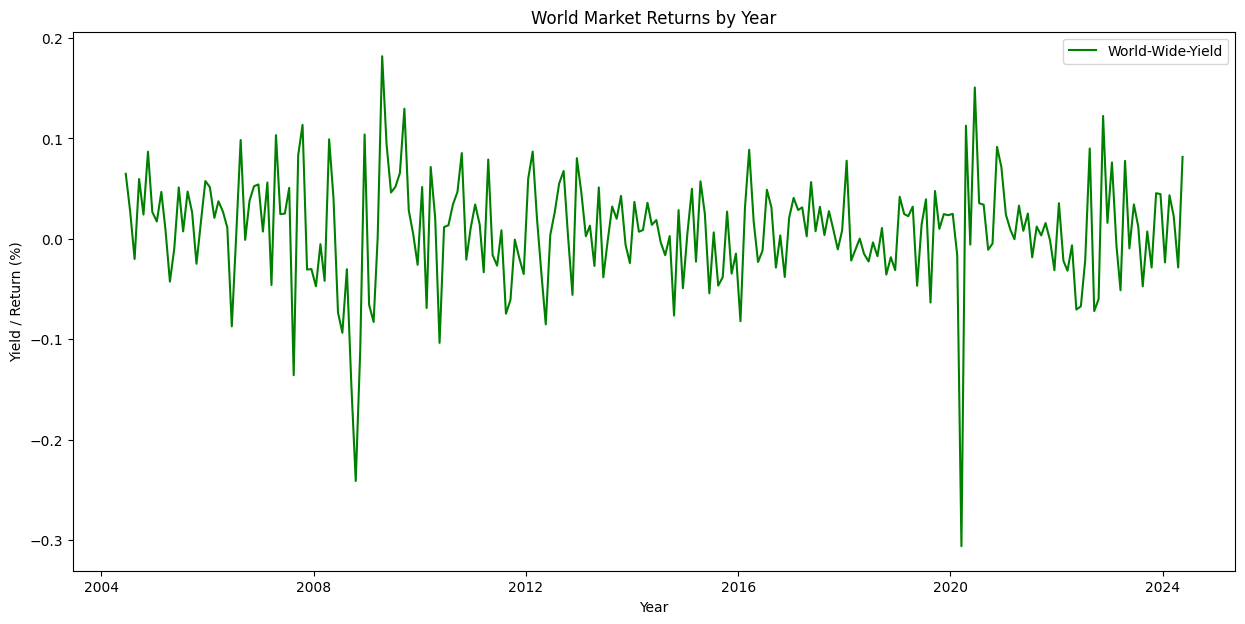

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(World_Market_Return.index, World_Market_Return, label='World-Wide-Yield', color='green')
plt.title('World Market Returns by Year')
plt.xlabel('Year')
plt.ylabel('Yield / Return (%)')
plt.legend()
plt.grid(False)
plt.show()

In [7]:
annualized_mean_returns = returns_df.mean() * 12
annualized_std_devs = returns_df.std() * np.sqrt(12)
rfr = 0.029716
sharpe_ratios = (annualized_mean_returns - rfr) / annualized_std_devs

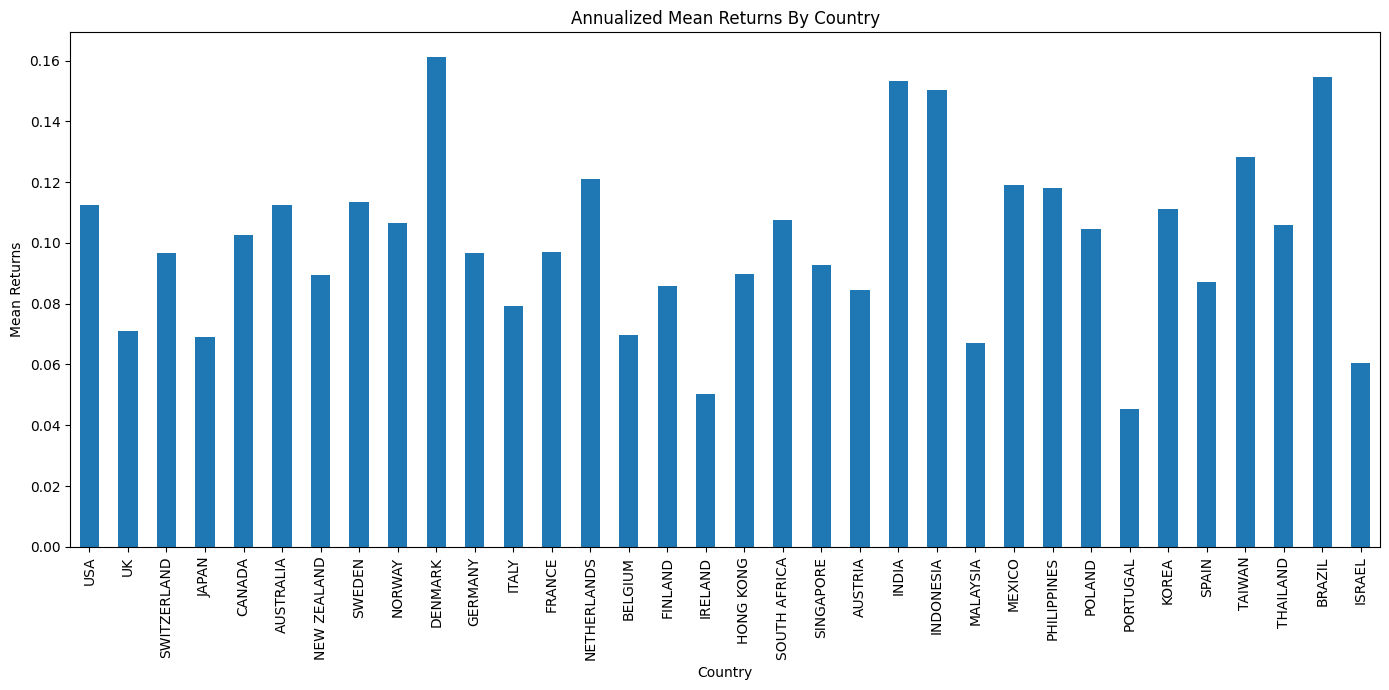

In [8]:
# Plot the Annualized Mean Returns
plt.figure(figsize=(14, 7))
annualized_mean_returns.plot(kind='bar')
plt.title('Annualized Mean Returns By Country')
plt.xlabel('Country')
plt.ylabel('Mean Returns')
plt.tight_layout()
plt.show()

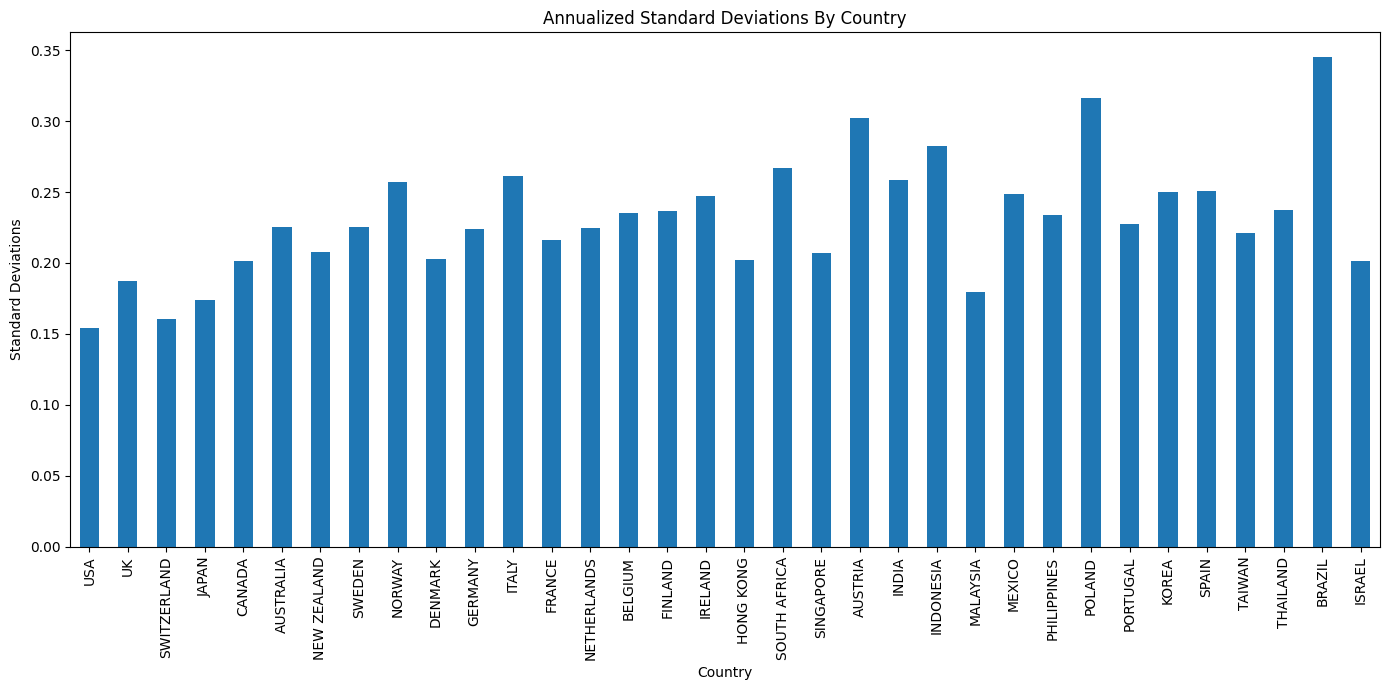

In [9]:
# Plot the Annualized Standard Deviations
plt.figure(figsize=(14, 7))
annualized_std_devs.plot(kind='bar')
plt.title('Annualized Standard Deviations By Country')
plt.xlabel('Country')
plt.ylabel('Standard Deviations')
plt.tight_layout()
plt.show()

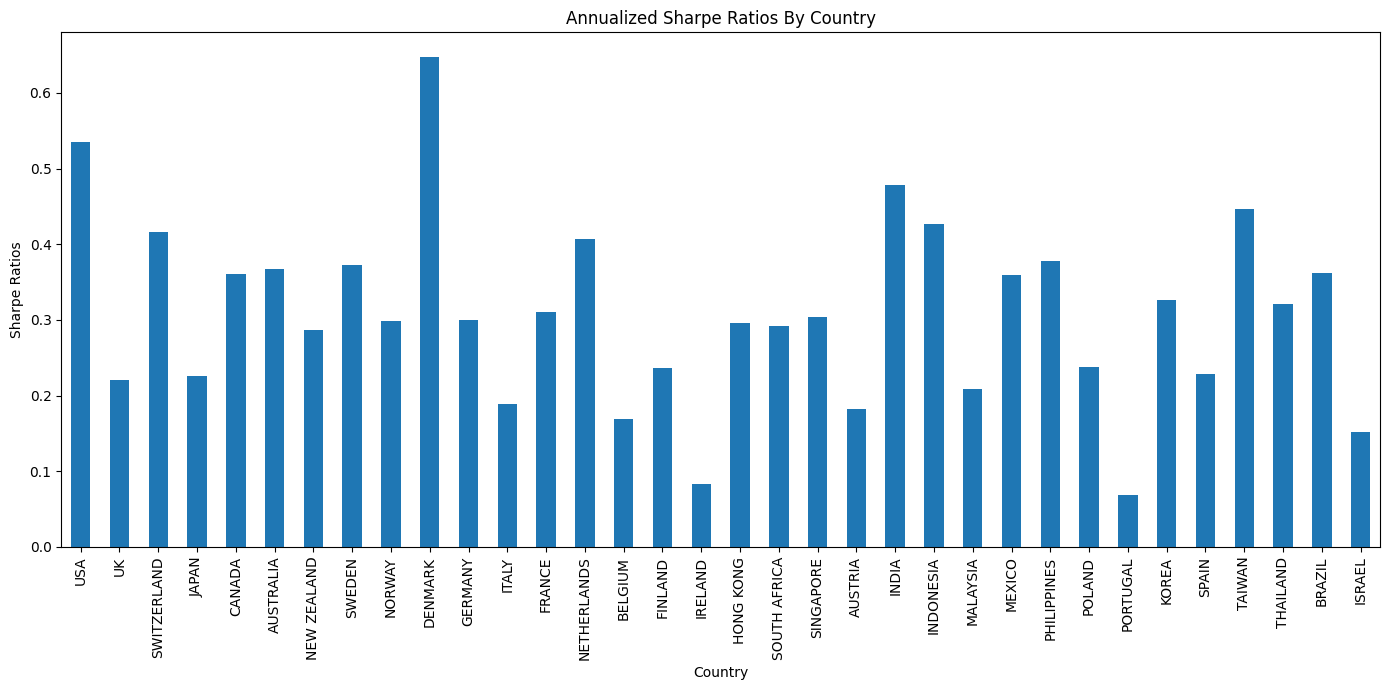

In [10]:
# Plot the Annualized Sharpe Ratios
plt.figure(figsize=(14, 7))
sharpe_ratios.plot(kind='bar')
plt.title('Annualized Sharpe Ratios By Country')
plt.xlabel('Country')
plt.ylabel('Sharpe Ratios')
plt.tight_layout()
plt.show()

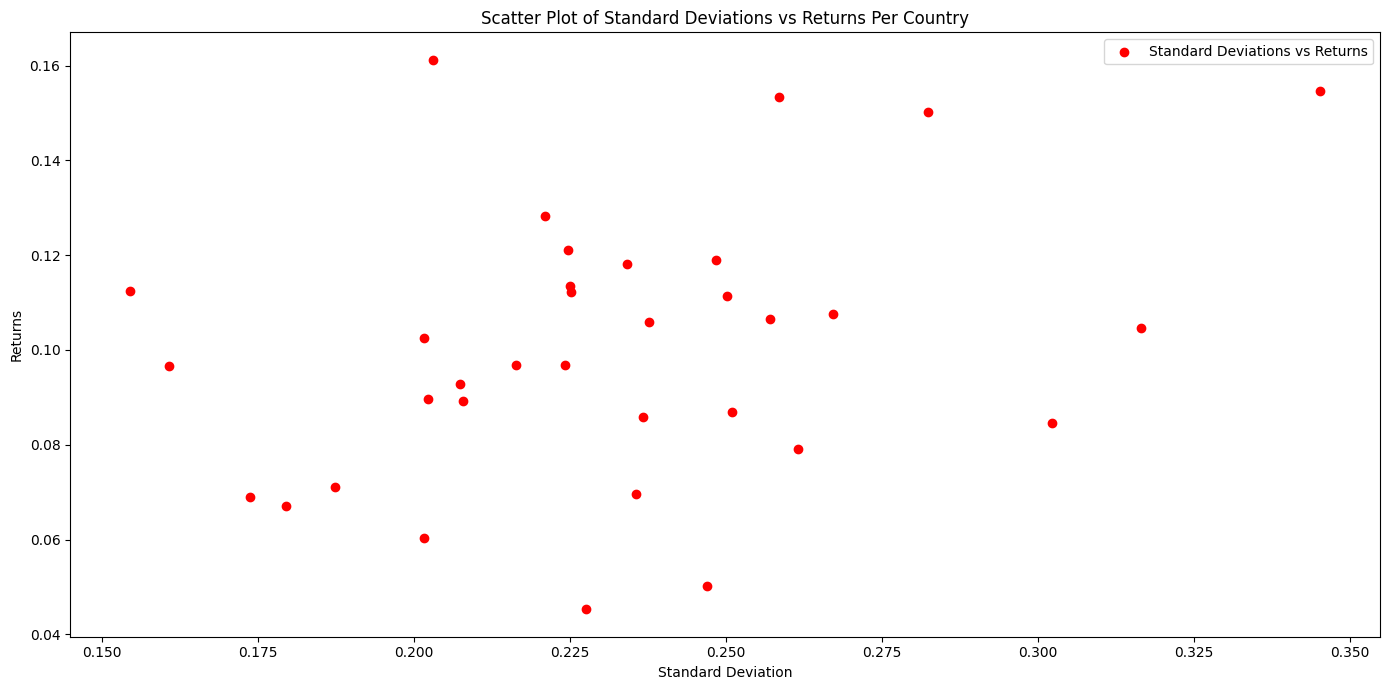

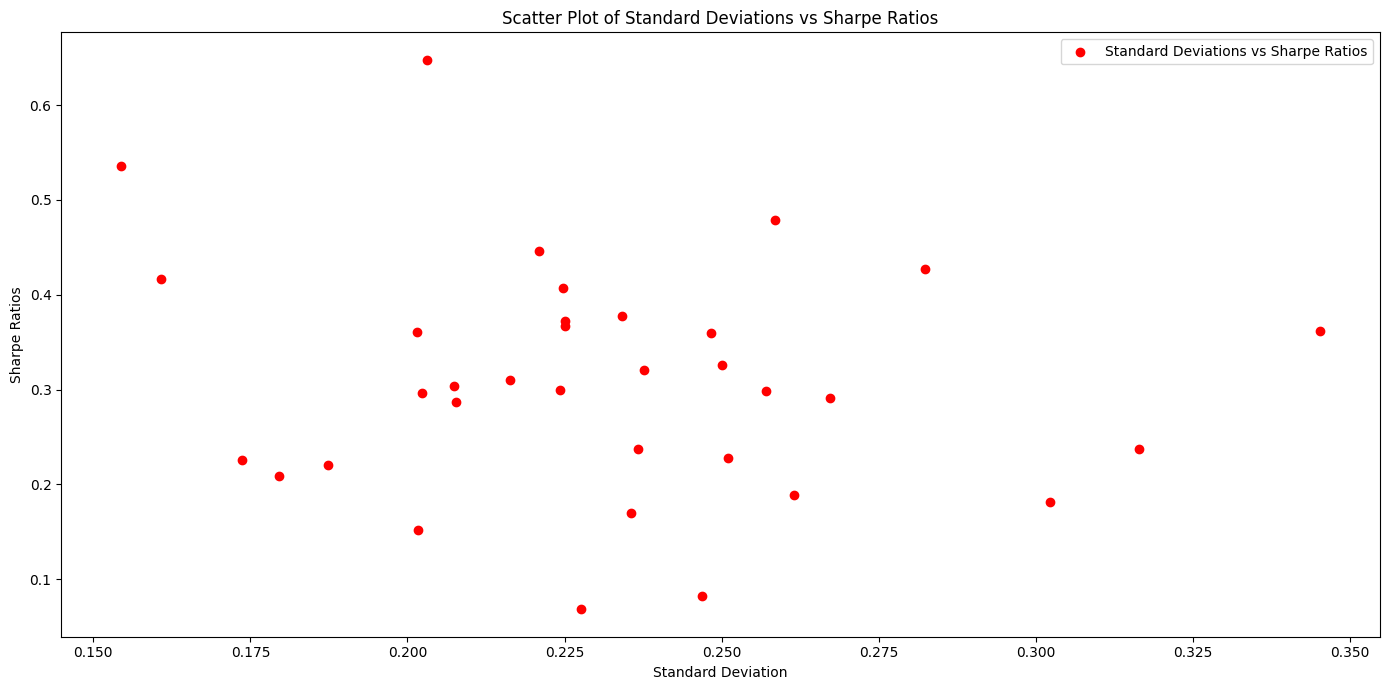

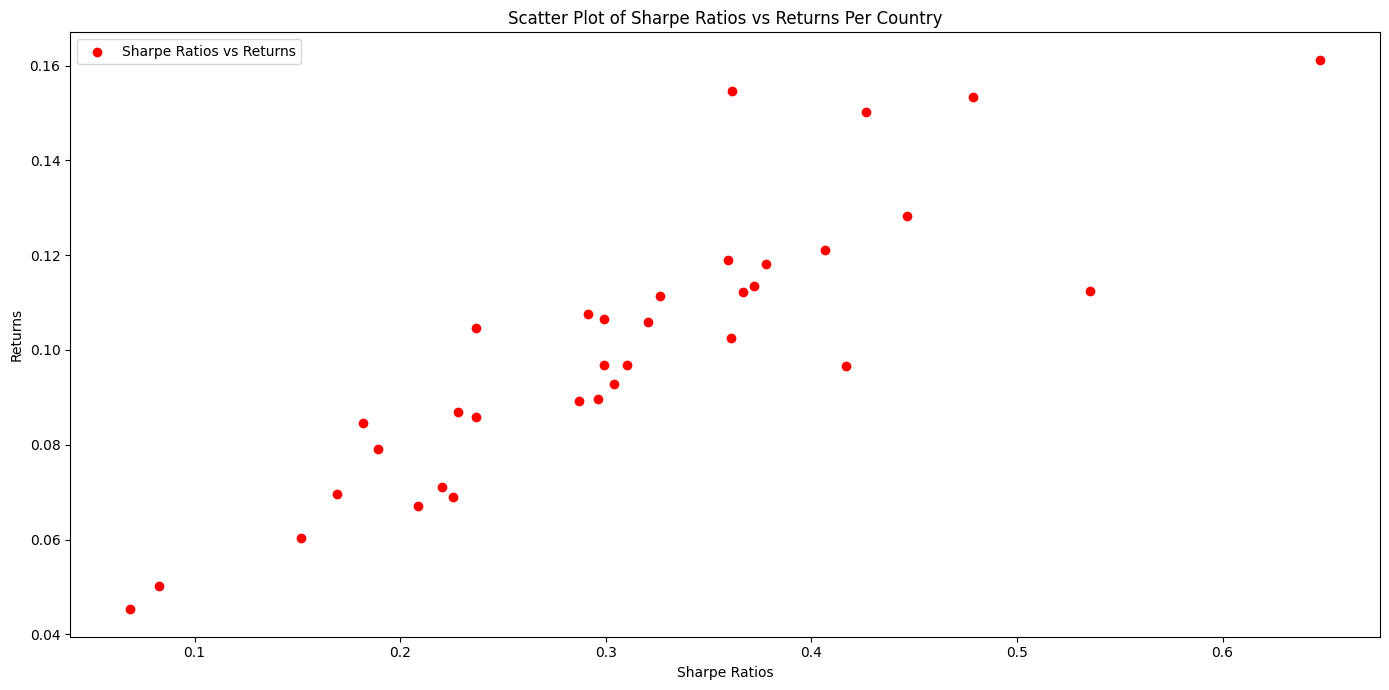

In [11]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(annualized_std_devs, annualized_mean_returns, label='Standard Deviations vs Returns', color='red')
ax.set_title(f'Scatter Plot of Standard Deviations vs Returns Per Country')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Returns')
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(annualized_std_devs, sharpe_ratios, label='Standard Deviations vs Sharpe Ratios', color='red')
ax.set_title(f'Scatter Plot of Standard Deviations vs Sharpe Ratios')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Sharpe Ratios')
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(sharpe_ratios, annualized_mean_returns, label='Sharpe Ratios vs Returns', color='red')
ax.set_title(f'Scatter Plot of Sharpe Ratios vs Returns Per Country')
ax.set_xlabel('Sharpe Ratios')
ax.set_ylabel('Returns')
ax.legend()
plt.tight_layout()
plt.show()

In [12]:
returns_df['World Market Return'] = World_Market_Return

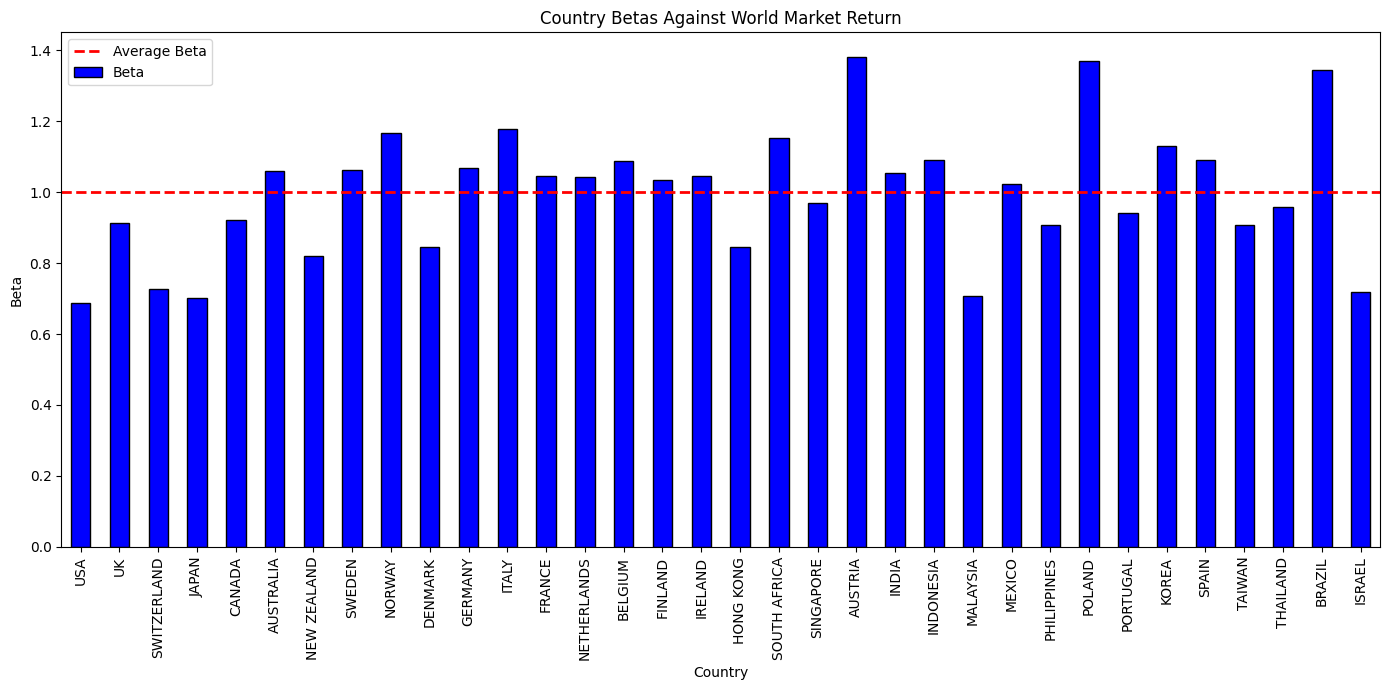

                  Beta
USA           0.686608
UK            0.911802
SWITZERLAND   0.728157
JAPAN         0.701016
CANADA        0.922639
AUSTRALIA     1.058424
NEW ZEALAND   0.820146
SWEDEN        1.063155
NORWAY        1.166772
DENMARK       0.846720
GERMANY       1.069199
ITALY         1.177062
FRANCE        1.046611
NETHERLANDS   1.043449
BELGIUM       1.086629
FINLAND       1.035440
IRELAND       1.046982
HONG KONG     0.845250
SOUTH AFRICA  1.153618
SINGAPORE     0.969464
AUSTRIA       1.381563
INDIA         1.053210
INDONESIA     1.089399
MALAYSIA      0.706044
MEXICO        1.022104
PHILIPPINES   0.908191
POLAND        1.368744
PORTUGAL      0.942161
KOREA         1.130312
SPAIN         1.089485
TAIWAN        0.906229
THAILAND      0.958604
BRAZIL        1.345254
ISRAEL        0.719555

Countries with Beta > 1.0 (High Beta):
                  Beta
AUSTRALIA     1.058424
SWEDEN        1.063155
NORWAY        1.166772
GERMANY       1.069199
ITALY         1.177062
FRANCE        1.0

In [13]:
# Function to calculate beta
def calculate_beta(returns, market_returns):
    X = sm.add_constant(market_returns)
    model = sm.OLS(returns, X).fit()
    return model.params[1]

# Calculate beta for each country
betas = {}
for country in returns_df.columns:
    if country != 'World Market Return':
        betas[country] = calculate_beta(returns_df[country], returns_df['World Market Return'])

# Convert the betas to a DataFrame
betas_df = pd.DataFrame.from_dict(betas, orient='index', columns=['Beta'])

# Calculate Average beta
betas_df['Average Beta'] = betas_df['Beta'].mean()

# Plot the betas
plt.figure(figsize=(14, 7))
betas_df['Beta'].plot(kind='bar', color='blue', edgecolor='black')
plt.axhline(y=betas_df['Average Beta'].any(), color='red', linestyle='--', linewidth=2, label='Average Beta')
plt.title('Country Betas Against World Market Return')
plt.xlabel('Country')
plt.ylabel('Beta')
plt.legend()
plt.tight_layout()
plt.show()

# Print the betas
print(betas_df.drop(columns=['Average Beta']))

# Interpretation of findings
high_beta_countries = (betas_df[betas_df['Beta'] > betas_df['Average Beta']]).drop(columns=['Average Beta'])
low_beta_countries = betas_df[betas_df['Beta'] < betas_df['Average Beta']].drop(columns=['Average Beta'])

print("\nCountries with Beta > 1.0 (High Beta):")
print(high_beta_countries)

print("\nCountries with Beta < 1.0 (Low Beta):")
print(low_beta_countries)

In [15]:
# Calculate the momentum signal for each country

# do not include the most recent month make gianni do it


# Calculate the momentum signal for each country
def calculate_momentum_signal(returns):
    # Calculate cumulative return over the past 12 months excluding the most recent month
    cumulative_return = (1 + returns.shift(1)).rolling(window=12).apply(np.prod, raw=True) - 1
    return cumulative_return

# Calculate the momentum signal for each country in the sample and for every month
momentum_signals = returns_df.iloc[:, :-1].apply(calculate_momentum_signal)

# Remove the initial months with NaN values caused by the rolling window
momentum_signals = momentum_signals.dropna()

# Display the first few rows of the momentum signals
print(momentum_signals.head(15))

                 USA        UK  SWITZERLAND     JAPAN    CANADA  AUSTRALIA  \
Date                                                                         
2005-06-17  0.107344  0.193849     0.136541  0.123645  0.288082   0.360787   
2005-07-17  0.100103  0.162371     0.114384  0.020265  0.330195   0.466365   
2005-08-17  0.141786  0.162108     0.143413  0.013086  0.335693   0.311756   
2005-09-17  0.155646  0.242507     0.249019  0.162977  0.408873   0.452471   
2005-10-17  0.123593  0.223230     0.256713  0.193696  0.451517   0.461418   
2005-11-17  0.099844  0.144534     0.250422  0.216198  0.306982   0.293805   
2005-12-17  0.079775  0.087401     0.161891  0.203717  0.234081   0.198162   
2006-01-17  0.090243  0.109749     0.226323  0.291479  0.342827   0.218787   
2006-02-17  0.112473  0.140631     0.269192  0.267542  0.389265   0.259608   
2006-03-17  0.099380  0.091341     0.237247  0.267742  0.353299   0.143794   
2006-04-17  0.125041  0.137840     0.234361  0.302867  0.313348 

In [16]:
returns_df = returns_df.drop(columns=['World Market Return'])  # We need to drop world because otherwise mess pepega

In [17]:
# Initialize DataFrame to store monthly portfolio returns
momentum_portfolio_returns = pd.DataFrame(index=returns_df.index, columns=['Portfolio1', 'Portfolio2', 'Portfolio3', 'Portfolio4', 'Portfolio5'])

In [18]:
# Iterate through each month to form portfolios and calculate returns
for date in momentum_signals.index[12:]:
    # Sort countries based on momentum signal
    sorted_countries = momentum_signals.loc[date].dropna().sort_values()
    # Split countries into 5 portfolios
    portfolios = np.array_split(sorted_countries.index, 5)
    
    # Calculate the return for each portfolio in the subsequent month
    for i, portfolio in enumerate(portfolios):
        momentum_portfolio_returns.loc[date, f'Portfolio{i+1}'] = returns_df.loc[date, portfolio].mean()

In [19]:
# Drop rows with NaN values
momentum_portfolio_returns = momentum_portfolio_returns.dropna()

# Calculate cumulative returns for the portfolios
cumulative_returns = (1 + momentum_portfolio_returns).cumprod() - 1

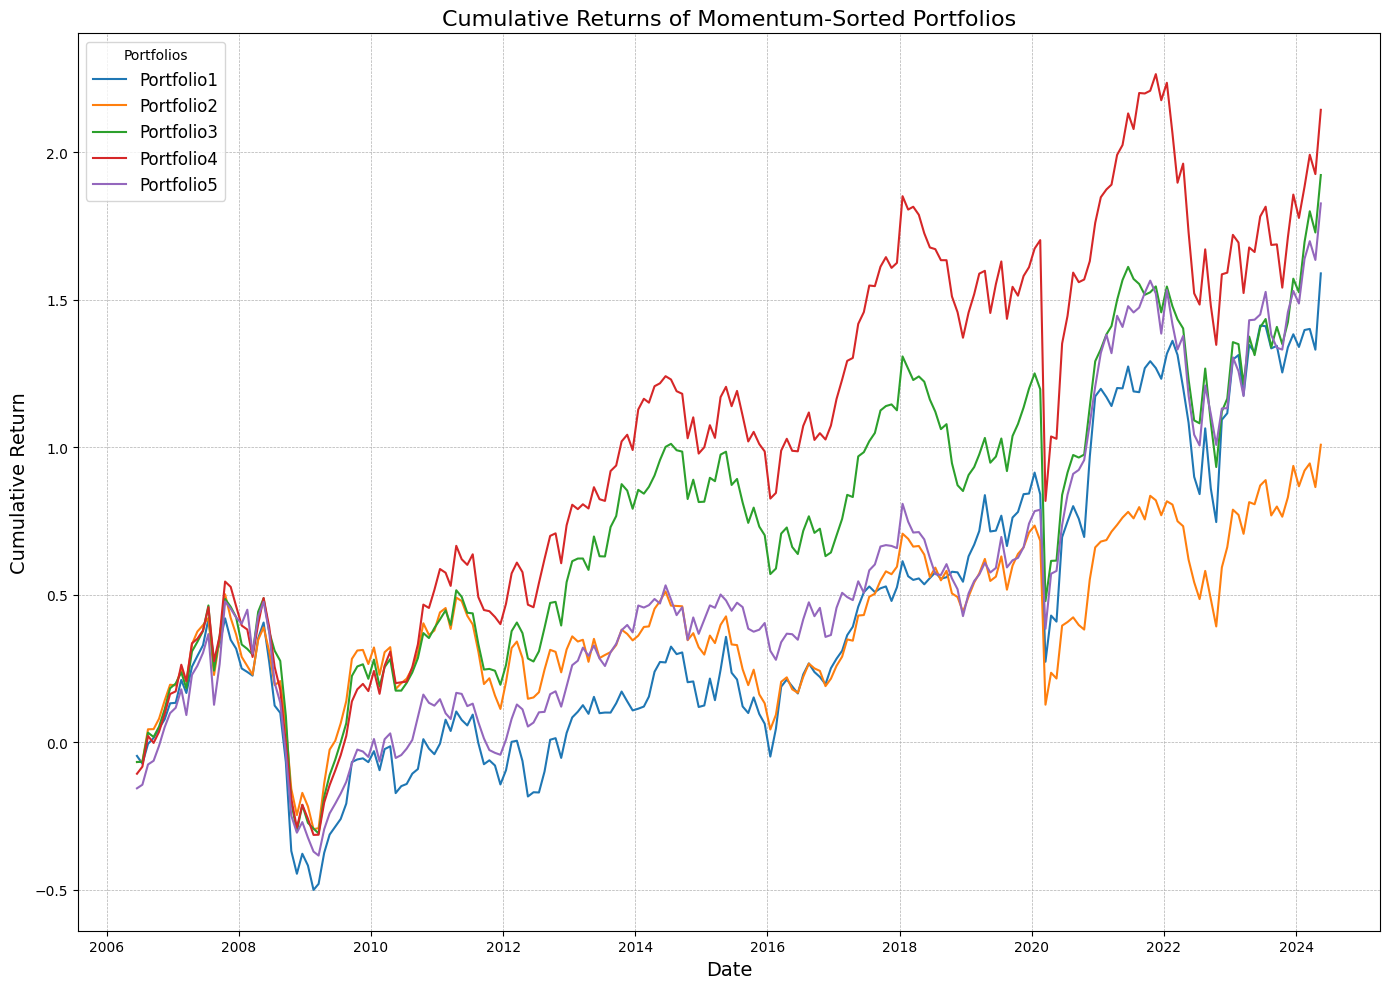

In [20]:
plt.figure(figsize=(14, 10))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)

plt.title('Cumulative Returns of Momentum-Sorted Portfolios', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend(title='Portfolios', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [28]:
# Update the summary statistics for the momentum portfolios
mean_returns = momentum_portfolio_returns.mean() * 12
volatility = momentum_portfolio_returns.std() * np.sqrt(12)
sharpe_ratio = (mean_returns - rfr) / volatility

rfr = 0.029716

# Annualize the risk-free rate
rfr_annualized = rfr * 12

summary_stats = pd.DataFrame({
    'Mean Return (Annualized)': mean_returns,
    'Volatility (Annualized)': volatility,
    'Sharpe Ratio': sharpe_ratio
}, index=['Portfolio1', 'Portfolio2', 'Portfolio3', 'Portfolio4', 'Portfolio5'])

print("Summary Statistics for Momentum-Sorted Portfolios")
print(summary_stats)

Summary Statistics for Momentum-Sorted Portfolios
            Mean Return (Annualized)  Volatility (Annualized)  Sharpe Ratio
Portfolio1                  0.081858                 0.235877      0.221057
Portfolio2                  0.060460                 0.204651      0.150227
Portfolio3                  0.081513                 0.203449      0.254597
Portfolio4                  0.084272                 0.198092      0.275406
Portfolio5                  0.077174                 0.194203      0.244372


Summary Statistics for HML Portfolio
               Mean Return (Annualized)  Volatility (Annualized)  Sharpe Ratio
HML Portfolio                 -0.004684                 0.146769     -0.234384


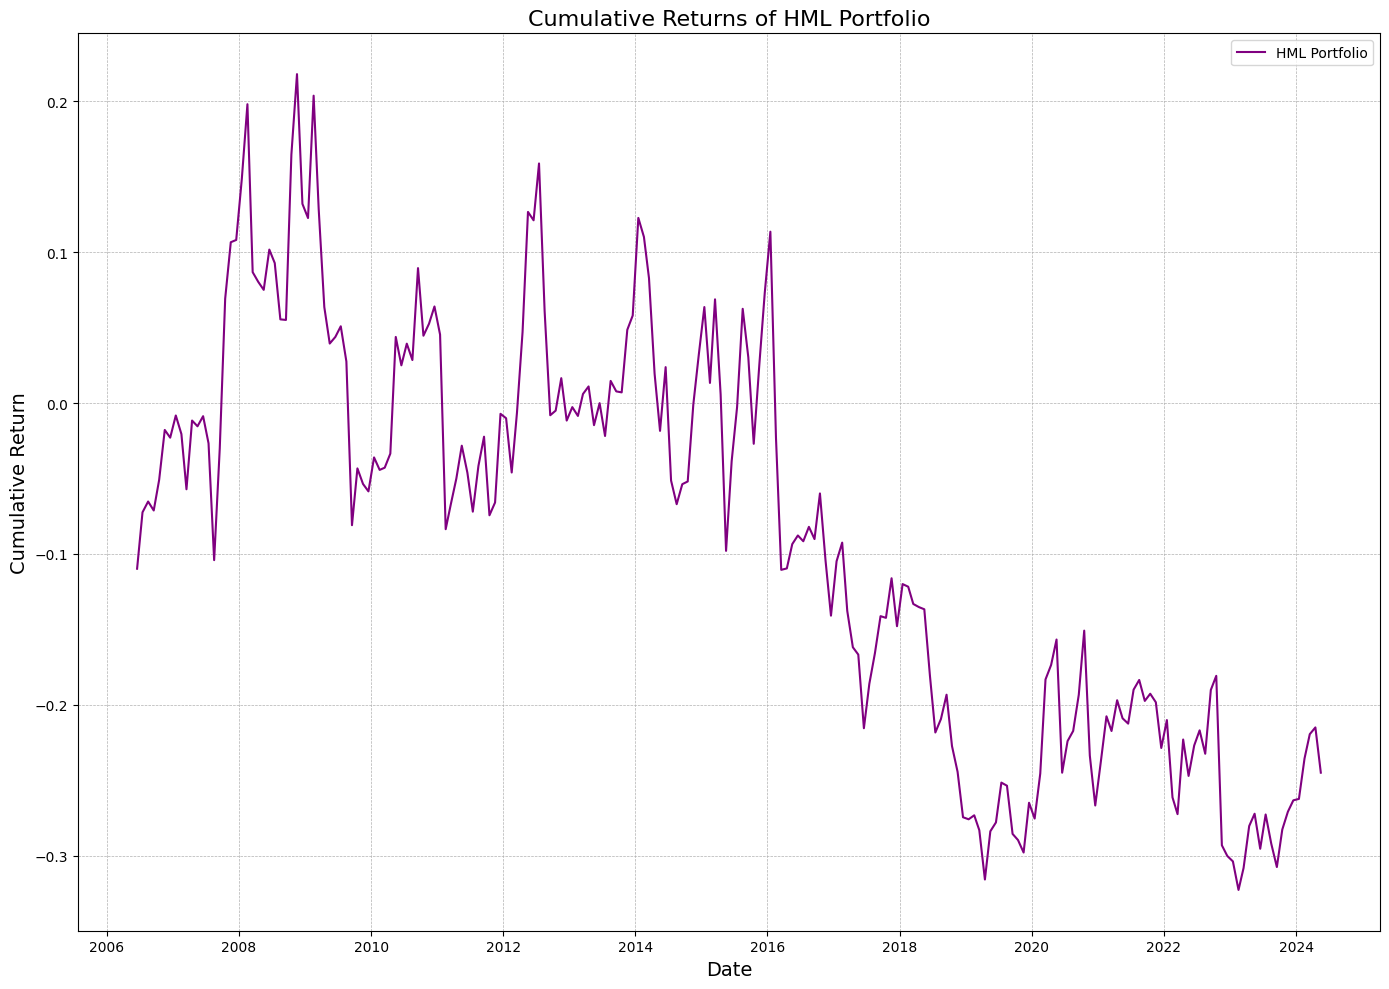

In [29]:
# note that the highest momentum is portfolio 5 and that the lowest momentum is 1

# Calculate the HML portfolio returns
hml_returns = momentum_portfolio_returns['Portfolio5'] - momentum_portfolio_returns['Portfolio1']

# Calculate annualized mean return, volatility, and Sharpe ratio for the HML portfolio
hml_mean_return = hml_returns.mean() * 12
hml_volatility = hml_returns.std() * np.sqrt(12)
hml_sharpe_ratio = (hml_mean_return - rfr) / hml_volatility

# Display the summary statistics for the HML portfolio
hml_summary_stats = pd.DataFrame({
    'Mean Return (Annualized)': [hml_mean_return],
    'Volatility (Annualized)': [hml_volatility],
    'Sharpe Ratio': [hml_sharpe_ratio]
}, index=['HML Portfolio'])

print("Summary Statistics for HML Portfolio")
print(hml_summary_stats)

# Plot the cumulative returns of the HML portfolio
hml_cumulative_returns = (1 + hml_returns).cumprod() - 1
plt.figure(figsize=(14, 10))
plt.plot(hml_cumulative_returns, label='HML Portfolio', color='purple')
plt.title('Cumulative Returns of HML Portfolio', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [30]:
# Parameters
start_month = 60  # starting point to have a 5-year history for the covariance matrix
info_coefficient = 0.02
risk_aversion_coefficient = 4.0  # risk-aversion coefficient

# Calculate residual return volatility
residual_volatility = returns_df.iloc[:start_month].std().mean()
print("Residual Return Volatility:", residual_volatility)

# Calculate momentum signals
momentum_signals = returns_df.apply(calculate_momentum_signal).dropna()

# Transform the momentum signals to alphas
alphas = momentum_signals * info_coefficient

# Display the alphas
print("Alphas:")
print(alphas.head())

# Function to calculate optimal weights
def calculate_optimal_weights(alphas, cov_matrix, risk_aversion_coefficient):
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    weights = inv_cov_matrix.dot(alphas) / risk_aversion_coefficient
    return weights / np.sum(np.abs(weights))

# Initialize lists to store monthly returns and turnover
optimal_returns = []
turnover = []
previous_weights = None

# Calculate monthly returns based on optimal weights for each subsequent month
for i in range(start_month, len(alphas) - 1):
    # Update the covariance matrix and alphas
    cov_matrix = returns_df.iloc[i-60:i].cov()
    alphas_current = alphas.iloc[i].values.reshape(-1)
    
    # Calculate optimal weights
    optimal_weights = calculate_optimal_weights(alphas_current, cov_matrix, risk_aversion_coefficient)
    
    # Ensure next month's returns are a 1D array with the correct number of assets
    next_month_returns = returns_df.iloc[i+1, :].values.reshape(-1)
    
    # Calculate the return for the next month
    next_month_return = np.dot(optimal_weights, next_month_returns)
    optimal_returns.append(next_month_return)
    
    # Calculate turnover (assuming previous weights are equally distributed if not available)
    if previous_weights is not None:
        monthly_turnover = np.sum(np.abs(optimal_weights - previous_weights))
        turnover.append(monthly_turnover)
    previous_weights = optimal_weights

# Convert the list of optimal returns to a DataFrame
optimal_returns_df = pd.DataFrame(optimal_returns, index=returns_df.index[start_month+1:start_month+1+len(optimal_returns)], columns=['Optimal Returns'])

# Optional: Convert the list of turnovers to a DataFrame
turnover_df = pd.DataFrame(turnover, index=returns_df.index[start_month+1:start_month+1+len(turnover)], columns=['Turnover'])

# Display the first few rows of the optimal returns and turnover
print("Optimal Returns:")
print(optimal_returns_df.head())
print("Turnover:")
print(turnover_df.head())

Residual Return Volatility: 0.08151440160124307
Alphas:
                 USA        UK  SWITZERLAND     JAPAN    CANADA  AUSTRALIA  \
Date                                                                         
2005-06-17  0.002147  0.003877     0.002731  0.002473  0.005762   0.007216   
2005-07-17  0.002002  0.003247     0.002288  0.000405  0.006604   0.009327   
2005-08-17  0.002836  0.003242     0.002868  0.000262  0.006714   0.006235   
2005-09-17  0.003113  0.004850     0.004980  0.003260  0.008177   0.009049   
2005-10-17  0.002472  0.004465     0.005134  0.003874  0.009030   0.009228   

            NEW ZEALAND    SWEDEN    NORWAY   DENMARK   GERMANY     ITALY  \
Date                                                                        
2005-06-17     0.006916  0.006169  0.008954  0.006957  0.003950  0.005986   
2005-07-17     0.007531  0.005189  0.010186  0.006821  0.003574  0.004924   
2005-08-17     0.004868  0.005099  0.010596  0.004925  0.003841  0.004679   
2005-09-17  

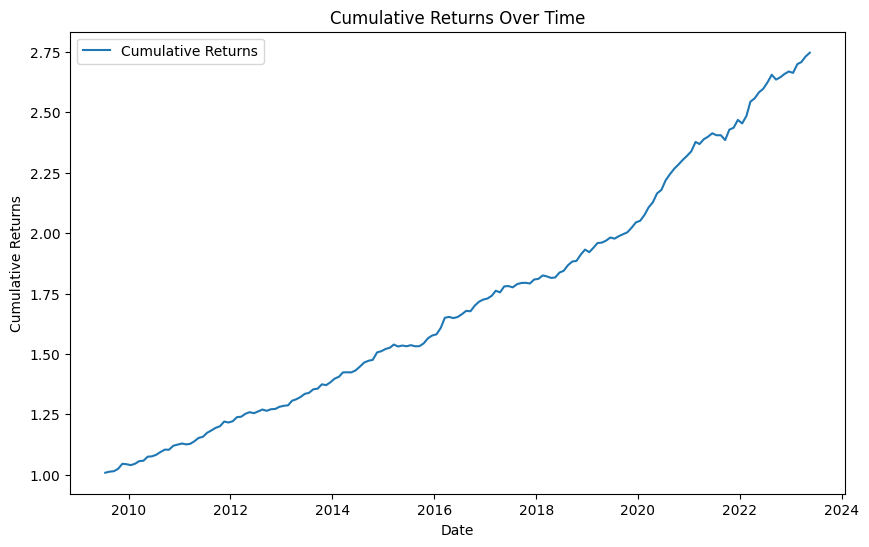

In [31]:
# Plot cumulative returns
optimal_returns_df['Cumulative Returns'] = (1 + optimal_returns_df['Optimal Returns']).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(optimal_returns_df.index, optimal_returns_df['Cumulative Returns'], label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.show()